In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, shutil
import statistics
import json 
import requests
from difflib import SequenceMatcher
import sys
import csv
#sys.path.insert(1, '/home/marinedjaffardjy/Documents/wf_features/src/parsing')
#import parsing_snkmk as ps
#import get_characteristics as t
import json

In [2]:
def importing_json_files(file_wf):
    f_wf = open(file_wf) #informations for nf
    # returns JSON object as
    # a dictionary
    wf = json.load(f_wf)
    f_wf.close
    return wf

In [3]:
#importing the process info
proc_nf = importing_json_files('json/nf_all_proc.json')
proc_nf_tool = importing_json_files('json/nf_proc_tool.json')
proc_snk = importing_json_files('json/snk_rule_info.json')
proc_snk_tool = importing_json_files('json/snk_rule_info_tool.json')


In [4]:
len(proc_nf)

22620

In [5]:
len(proc_nf_tool)

9652

In [20]:
#importing the wf info
wf_nf = importing_json_files('json/nf_all_wf.json')
#wf_nf_tool = importing_json_files('json/nf_tool_wf.json')
wf_snk = importing_json_files('json/wf_snk_added_info.json')
#wf_snk_tool = importing_json_files('json/wf_snk_added_info_tool.json')


In [7]:
#importing the wf and auth dict (github info)
dict_nf = importing_json_files('json/wf_new_crawl_nextflow.json')
auth_nf = importing_json_files('json/author_clem_nf.json')
dict_snk = importing_json_files('json/wf_crawl_snakemake.json')
auth_snk = importing_json_files('json/author_clem_snk.json')


In [22]:
#get list of wf with at least 1 tool
def get_list_wf_tool(proc_list):
    wf_tool = []
    for proc in proc_list:
        wf_tool.append(proc["wf_orig"])
    
    return list(set(wf_tool))

wf_nf_tool = get_list_wf_tool(proc_nf_tool) 
wf_snk_tool = get_list_wf_tool(proc_snk_tool)  

In [9]:
proc_nf[0]

{'owner': 'ABMicroBioinf',
 'wf_orig': 'magph',
 'name': 'MINIMAP2_ALIGN',
 'code': 'process MINIMAP2_ALIGN {\n    tag "$meta.id"\n    label \'process_medium\'\n\n    conda (params.enable_conda ? \'bioconda::minimap2=2.21\' : null)\n    container "${ workflow.containerEngine == \'singularity\' && !task.ext.singularity_pull_docker_container ?\n        \'https://depot.galaxyproject.org/singularity/minimap2:2.21--h5bf99c6_0\' :\n        \'quay.io/biocontainers/minimap2:2.21--h5bf99c6_0\' }"\n\n    input:\n    tuple val(meta), path(reads)\n    path reference\n\n    output:\n    tuple val(meta), path("*.paf"), emit: paf\n    path "versions.yml" , emit: versions\n\n    script:\n    def args = task.ext.args ?: \'\'\n    def prefix = task.ext.prefix ?: "${meta.id}"\n    def input_reads = meta.single_end ? "$reads" : "${reads[0]} ${reads[1]}"\n    """\n    minimap2 \\\\\n        $args \\\\\n        -t $task.cpus \\\\\n        $reference \\\\\n        $input_reads \\\\\n        > ${prefix}.paf\n

In [10]:
proc_nf_no_tool = []
for proc in proc_nf:
    if len(proc['tools'])==0:
        proc_nf_no_tool.append(proc)
len(proc_nf_no_tool)

12968

In [26]:
wf_at_least_no_tool = []
for proc in proc_nf_no_tool:
    wf_at_least_no_tool.append(proc["wf_orig"])
wf_at_least_no_tool = list(set(wf_at_least_no_tool))

In [23]:
wf_nf_tool[0]

'nf-core-disambiguate'

In [27]:
wf_all_tool_proc = []
for wf in wf_nf_tool :
    for proc in proc_nf_no_tool:
        app = True
        if proc['wf_orig'] in wf_at_least_no_tool :
            app = False  
            break
    if app == True:
        wf_all_tool_proc.append(wf)

KeyboardInterrupt: 

In [ ]:
len(set(wf_all_tool_proc))

In [9]:
len(wf_snk_tool)

1257

In [10]:
def sim_proc(liste) :
    #compares the code of the snakemake processes - if the tools are exactly the same, they are identical, doesn't count the several occurences of a tool
    liste_proc = liste.copy()
    liste_simil = []
    while (len(liste_proc)!=0):
        simil2 = [liste_proc[0]]
        liste_proc.remove(simil2[0])
        #print(simil2[0]['tools'])
        liste_proc_temp = liste_proc
        for el in liste_proc :
            if(tuple(set(simil2[0]['tools']))==tuple(set(el['tools']))):
                simil2.append(el)
                liste_proc_temp.remove(el)
        liste_simil.append(simil2)
        liste_proc = liste_proc_temp
            #print(len(simil2))
    return liste_simil

In [11]:
sim_nf = sim_proc(proc_nf_tool)

In [24]:
groups_nf = pd.DataFrame(columns = ["groups"])
all_groups = []

for group in sim_nf:
    new_group = []
    for el in group :
        new_group.append(el['wf_orig']+':'+el['name'])
    all_groups.append(new_group)

groups_nf["groups"]= all_groups

In [27]:
groups_nf.to_csv('csv/groups_sim_nf_names.csv')

In [33]:
for group in groups_nf["groups"]:
    all_proc_nf = []
    for el in group:
        all_proc_nf.append(el)
len(all_proc_nf)

9652

9441

In [34]:
sim_snk = sim_proc(proc_snk_tool)

In [56]:
def sim_to_df_nf(groups_list, dict_wf): 
    groups_sim_df = pd.DataFrame(columns = ['nb_reuse', 'tools','nb_own', 'list_own', 'nb_contrib','list_contrib','nb_wf','list_wf'])
    for group in groups_list :
        list_own = []
        list_wf = []
        list_contrib = []
        for el in group :
            list_own.append(el['owner'])
            list_wf.append(el['wf_orig'])
            name_wf = el['owner']+'/'+el['wf_orig']
            if (name_wf in dict_wf.keys()):
                for contr in dict_wf[name_wf]['contributors']:
                    list_contrib.append(contr)
            elif (name_wf+".nf" in dict_wf.keys()):
                for contr in dict_wf[name_wf+".nf"]['contributors']:
                    list_contrib.append(contr)
        list_own = list(set(list_own))
        list_wf = list(set(list_wf))
        list_contrib = list(set(list_contrib))
        #print(group[0]['tools'])
        groups_sim_df = groups_sim_df.append({'nb_reuse' : len(group),
                                              'tools' : group[0]['tools'],
                                             'nb_own' : len(set(list_own)),
                                             'list_own' : list_own ,
                                             'nb_wf' : len(set(list_wf)),
                                             'list_wf' : list(set(list_wf)),
                                             'list_contrib' : list(set(list_contrib)),
                                             'nb_contrib' :len(set(list_contrib))}, ignore_index = True)
    #print(groups_sim_df)
    return groups_sim_df

In [57]:
def sim_to_df_snk(groups_list, dict_wf): 
    groups_sim_df = pd.DataFrame(columns = ['nb_reuse', 'tools','nb_own', 'list_own', 'nb_contrib','list_contrib','nb_wf','list_wf'])
    for group in groups_list :
        list_own = []
        list_wf = []
        list_contrib = []
        for el in group :
            list_own.append(el['owner'])
            list_wf.append(el['wf_orig'])
            name_wf = el['wf_orig'].split('/')[0]+'/'+el['wf_orig'].split('/')[1]
            for contr in dict_wf[name_wf]['contributors']:
                list_contrib.append(contr)
        list_own = list(set(list_own))
        list_wf = list(set(list_wf))
        list_contrib = list(set(list_contrib))
        groups_sim_df = groups_sim_df.append({'nb_reuse' : len(group),
                                              'tools' : group[0]['tools'],
                                             'nb_own' : len(list_own),
                                             'list_own' : list_own ,
                                             'nb_wf' : len(list_wf),
                                             'list_wf' : list_wf,
                                             'list_contrib' : list_contrib,
                                             'nb_contrib' :len(list_contrib)}, ignore_index = True)
    return groups_sim_df

In [58]:
def verif_sim_proc(df_sim):
    values = set(tuple(i) for i in df_sim["tools"])
    temp_df_sim = df_sim
    new_df = pd.DataFrame()
    for val in values :
        val = list(val)
        sub_df = pd.DataFrame()
        #print(val)
        for i in range(0,len(temp_df_sim)):
            if (temp_df_sim.iloc[i]['tools']==val):
                sub_df = sub_df.append(temp_df_sim.iloc[i])          
        own = []
        contrib = []
        wf = []
        for i in range(0,len(sub_df)):
            for elo in sub_df.iloc[i]['list_own']:
                own.append(elo)
            for elc in sub_df.iloc[i]['list_contrib']:
                contrib.append(elc)
            for elw in sub_df.iloc[i]['list_wf']:
                wf.append(elw)
        #print(sub_df)
        new_df = new_df.append({'nb_reuse':sum(sub_df['nb_reuse']),
                               'tools': val,
                               'nb_own': len(set(own)),
                               'list_own':set(own),
                               'nb_contrib':len(set(contrib)),
                               'list_contrib':set(contrib),
                               'nb_wf': len(set(wf)),
                               'list_wf':set(wf)}, ignore_index = True)
    return new_df

In [59]:
%%time
df_sim_nf = sim_to_df_nf(sim_nf, dict_nf)
df_sim_snk = sim_to_df_snk(sim_snk, dict_snk)

CPU times: user 7.7 s, sys: 4 ms, total: 7.7 s
Wall time: 7.69 s


In [60]:
%%time
df_sim_nf = verif_sim_proc(df_sim_nf)
df_sim_snk = verif_sim_proc(df_sim_snk) 

CPU times: user 2min, sys: 15.4 ms, total: 2min
Wall time: 2min


In [61]:
df_sim_nf.head(10)

,list_contrib,list_own,list_wf,nb_contrib,nb_own,nb_reuse,nb_wf,tools
0,{ortzf},{vibbits},{NextFlow_pipelines},1.0,1.0,1.0,1.0,"[sampletrees, PowerShell, tmax, Annot, metabol..."
1,{octavia-c},{biomedbigdata},{nf-core-circRNA-sponging},1.0,1.0,2.0,1.0,[CIRCexplorer2]
2,"{erikrikarddaniel, alexandregilardet, arontomm...","{cidgoh, nf-core, sanger-tol}","{modules, cidgoh_qc, readmapping}",108.0,3.0,3.0,3.0,"[SAMtools, FastQC]"
3,"{erikrikarddaniel, alexandregilardet, arontomm...","{nf-core, jianhong}","{nf-core-hicar, modules}",107.0,2.0,2.0,2.0,[GenMAPP]
4,"{andreas-wilm, azure-pipelines[bot], brucemora...","{cgpu, gis-rpd, brucemoran}","{somatic_n-of-1, somatic_exome_n-of-1, rpd-sg1...",5.0,3.0,5.0,5.0,"[Picard, MarkDuplicates (IP), SAMtools, SAMtools]"
5,{rwtaylor},{rwtaylor},"{mpcr-analyses-pipelines, nextflow-pipelines}",1.0,1.0,4.0,2.0,"[BEDTools, BamTools]"
6,"{QuentinLetourneur, aghozlane}",{QuentinLetourneur},{Let-it-bin},2.0,1.0,1.0,1.0,"[clc_assembler, GATB, MEGAHIT]"
7,"{phelelani, lucacozzuto, melferink, alexthiery...","{phelelani, noelnamai, luslab, cmatKhan, bioco...","{allele_specific_RNAseq, nf-rnaSeqCount, Nextf...",20.0,9.0,9.0,9.0,[htseqcount]
8,{darlenewagner},{darlenewagner},{nextflowViral},1.0,1.0,1.0,1.0,[Smalt]
9,{pblaney},{pblaney},{mgp1000},1.0,1.0,4.0,1.0,[MSClust]


In [62]:
df_sim_snk.head(10)

,list_contrib,list_own,list_wf,nb_contrib,nb_own,nb_reuse,nb_wf,tools
0,{},{mscharmann},"{mscharmann/sexdelim/2, mscharmann/sexdelim/1}",0.0,1.0,2.0,2.0,"[BWA, SAMtools, SAMtools, SAMtools, seqtk, BED..."
1,"{DarioS, xiaoyan-xu, wdeleeuw, kernco, kittyl,...","{davidlevybooth, xiaoyan-xu, kernco, LoGT-KULe...","{penglbio/RNA_Seq/1, kernco/deg_pipeline/1, xi...",15.0,16.0,26.0,23.0,[htseqcount]
2,"{fburic, franciscozorrilla, sevance, elimoss, ...","{franciscozorrilla, Finn-Lab, skinmicrobiome, ...","{franciscozorrilla/metaGEM/2, skinmicrobiome/s...",13.0,5.0,12.0,8.0,[dRep]
3,{arvestad},{arvestad},"{arvestad/accuracy_in_prime/3, arvestad/accura...",1.0,1.0,2.0,2.0,[CS-PSeq-Gen]
4,"{vodkatad, samleenz}","{vodkatad, samleenz}","{vodkatad/snakegatk/14, samleenz/variant-calli...",2.0,2.0,2.0,2.0,[Platypus]
5,{burtonjz},{UMich-Mind-Lab},{UMich-Mind-Lab/pipeline-task-standard/1},1.0,1.0,1.0,1.0,[DBETH]
6,"{johnne, andnischneider}",{andnischneider},{andnischneider/its_workflow/2},2.0,1.0,1.0,1.0,[UNITE rDNA]
7,{pmenzel},{pmenzel},{pmenzel/ont-assembly-snake/1},1.0,1.0,1.0,1.0,"[TRAP, Minimap2, Racon]"
8,{sfrenk},{sfrenk},{sfrenk/variant_calling_pipeline/1},1.0,1.0,2.0,1.0,"[GATK, mQC, QUALITY, mdp]"
9,"{miramastoras, awreynolds}","{hennlab, hardingnj}","{hardingnj/snakeit/1, hennlab/snake-IBDne/2, h...",2.0,2.0,4.0,4.0,[SHAPEIT]


In [63]:
#save the files
df_sim_nf.to_csv('csv/df_sim_nf.csv')
df_sim_snk.to_csv('csv/df_sim_snk.csv')

In [28]:
# group the processes per nb of times reused
def grouping_sim_df_new (df_sim_n):
    df_sim = df_sim_n.copy()
    vals = set(list(df_sim["nb_reuse"])+list(df_sim["nb_wf"])+list(df_sim["nb_own"]))
    tot_group = len(df_sim_n)
    tot_wf = sum(df_sim_n["nb_wf"])
    tot_own = sum(df_sim_n["nb_own"])

    df_sim_group = pd.DataFrame(columns=["nb_reuse", "nb_proc","prop_proc","nb_own","prop_own","nb_wf","prop_wf"])
    for val in vals :
        nb_proc = len(df_sim.loc[df_sim["nb_reuse"]==val])
        prop_proc = nb_proc/tot_group
        nb_own = len(df_sim.loc[df_sim["nb_own"]==val])
        prop_own = nb_own/tot_group
        nb_wf = len(df_sim.loc[df_sim["nb_wf"]==val])
        prop_wf = nb_wf/tot_group
        df_sim_group = df_sim_group.append({"nb_reuse":val,
                                            "nb_proc":nb_proc,
                                            "prop_proc":prop_proc*100.0,
                                            "nb_own":nb_own,
                                            "prop_own":prop_own*100.0,
                                            "nb_wf":nb_wf,
                                            "prop_wf":prop_wf*100.0}, ignore_index = True)
    
    return df_sim_group.sort_values(by=["nb_reuse"], ascending=True)




In [29]:
df_groups_nf_new = grouping_sim_df_new(df_sim_nf)
df_groups_snk_new = grouping_sim_df_new(df_sim_snk)

In [80]:
df_groups_nf = grouping_sim_df(df_sim_nf)
df_groups_snk = grouping_sim_df(df_sim_snk)

In [85]:
#save the files
df_groups_nf.to_csv('csv/df_groups_nf.csv')
df_groups_snk.to_csv('csv/df_groups_snk.csv')

### Figure 3

In [24]:
# to recreate these graphs, simply import these:
df_groups_nf = pd.read_csv('csv/df_groups_nf.csv')
df_groups_snk= pd.read_csv('csv/df_groups_snk.csv')
df_sim_nf = pd.read_csv('csv/df_sim_nf.csv')
df_sim_snk = pd.read_csv('csv/df_sim_snk.csv')

In [25]:
[1,2,3]+[4,5,6]

[1, 2, 3, 4, 5, 6]

In [ ]:
# group the processes per nb of times reused
def grouping_sim_df_2 (df_sim_n):
    df_sim = df_sim_n.copy()
    vals = set(df_sim["nb_reuse"]+)
    tot_group = len(df_sim_n)
    tot_wf = sum(df_sim_n["nb_wf"])
    tot_own = sum(df_sim_n["nb_own"])

    df_sim_group = pd.DataFrame(columns=["nb_reuse","tool", "nb_proc","prop_proc","nb_own","prop_own","nb_wf","prop_wf"])
    for val in vals :
        sec_df = df_sim.loc[df_sim["nb_reuse"]==val]
        tools = []
        for el in sec_df["tools"]:
            tools.append(el)
        nb_proc = len(sec_df)
        prop_proc = nb_proc/tot_group
        nb_own = sum(sec_df["nb_own"])
        prop_own = nb_own/tot_own
        nb_wf = sum(sec_df["nb_wf"])
        prop_wf = nb_wf/tot_wf
        df_sim_group = df_sim_group.append({"nb_reuse":val,
                                            "tool":tools, 
                                            "nb_proc":nb_proc,
                                            "prop_proc":prop_proc*100.0,
                                            "nb_own":nb_own,
                                            "prop_own":prop_own*100.0,
                                            "nb_wf":nb_wf,
                                            "prop_wf":prop_wf*100.0}, ignore_index = True)
    
    return df_sim_group.sort_values(by=["nb_reuse"], ascending=True)

In [37]:
def sum_columns_df(df):
    dfret = pd.DataFrame(columns=["nb_reuse", "nb_proc","prop_proc","nb_own","prop_own","nb_wf","prop_wf"])
    return dfret.append({"nb_reuse":list(df["nb_reuse"])[0],
                      #"tool":list(df["tool"]), 
                      "nb_proc":df["nb_proc"].sum(),
                      "prop_proc":df["prop_proc"].sum(),
                      "nb_own":df["nb_own"].sum(),
                      "prop_own":df["prop_own"].sum(),
                      "nb_wf":df["nb_wf"].sum(),
                      "prop_wf":df["prop_wf"].sum()}, ignore_index=True)

In [14]:
sub_df = df_groups_nf.loc[df_groups_nf["nb_reuse"]>10].loc[df_groups_nf["nb_reuse"]<20]

In [34]:
def display_proportions_figure(df_init):
    # découpage du wor
    df = df_init.iloc[0:9]
    ranges = [10,30,60,100,500]
    labels = []
    for r in range(0,len(ranges)-1):
        labels.append(str(ranges[r])+"-"+str(ranges[r+1]))
        sub_df = df_init.loc[df_init["nb_reuse"]>ranges[r]].loc[df_init["nb_reuse"]<ranges[r+1]]
        df = df.append(sum_columns_df(sub_df))
    labels.append(str(ranges[-1])+"+")
    df = df.append(sum_columns_df(df_init.loc[df_init["nb_reuse"]>ranges[-1]]))
    fig_4 = df.plot(x="nb_reuse", y=["prop_proc", "prop_wf", 'prop_own'], kind="bar", color = ['orange','blue','red'], label = ['times used','workflows', 'authors'])
    fig_4.set_xticklabels(fig_4.get_xticklabels()[0:9]+ labels, rotation=80, size=5)
    fig_4.set_xlabel('Number of times used/workflows used in/authors used by')
    fig_4.set_ylabel('Percent of processors')
    fig_4.legend(loc='best')
    fig_4.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    
    return fig_4

In [67]:
def display_proportions_figure(df_init):
    # découpage du wor
    df = df_init.iloc[0:9]
    ranges = [10,30,60,100,500]
    labels = []
    for r in range(0,len(ranges)-1):
        labels.append(str(int(ranges[r]))+"-"+str(int(ranges[r+1])))
        sub_df = df_init.loc[df_init["nb_reuse"]>ranges[r]].loc[df_init["nb_reuse"]<ranges[r+1]]
        df = df.append(sum_columns_df(sub_df))
    labels.append(str(int(ranges[-1]))+"+")
    df = df.append(sum_columns_df(df_init.loc[df_init["nb_reuse"]>ranges[-1]]))
    fig_4 = df.plot(x="nb_reuse", y=["prop_proc", "prop_wf", 'prop_own'], kind="bar", color = ['orange','blue','red'], label = ['times used','workflows', 'authors'])
    fig_4.set_xticklabels(list(df_groups_nf_new.iloc[0:9]["nb_reuse"])+ labels, rotation=45, size=10)
    fig_4.set_xlabel('Number of times used/workflows used in/authors used by')
    fig_4.set_ylabel('Percent of processors')
    fig_4.legend(loc='best')
    fig_4.set_yscale('log')
    plt.show()
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    
    return fig_4

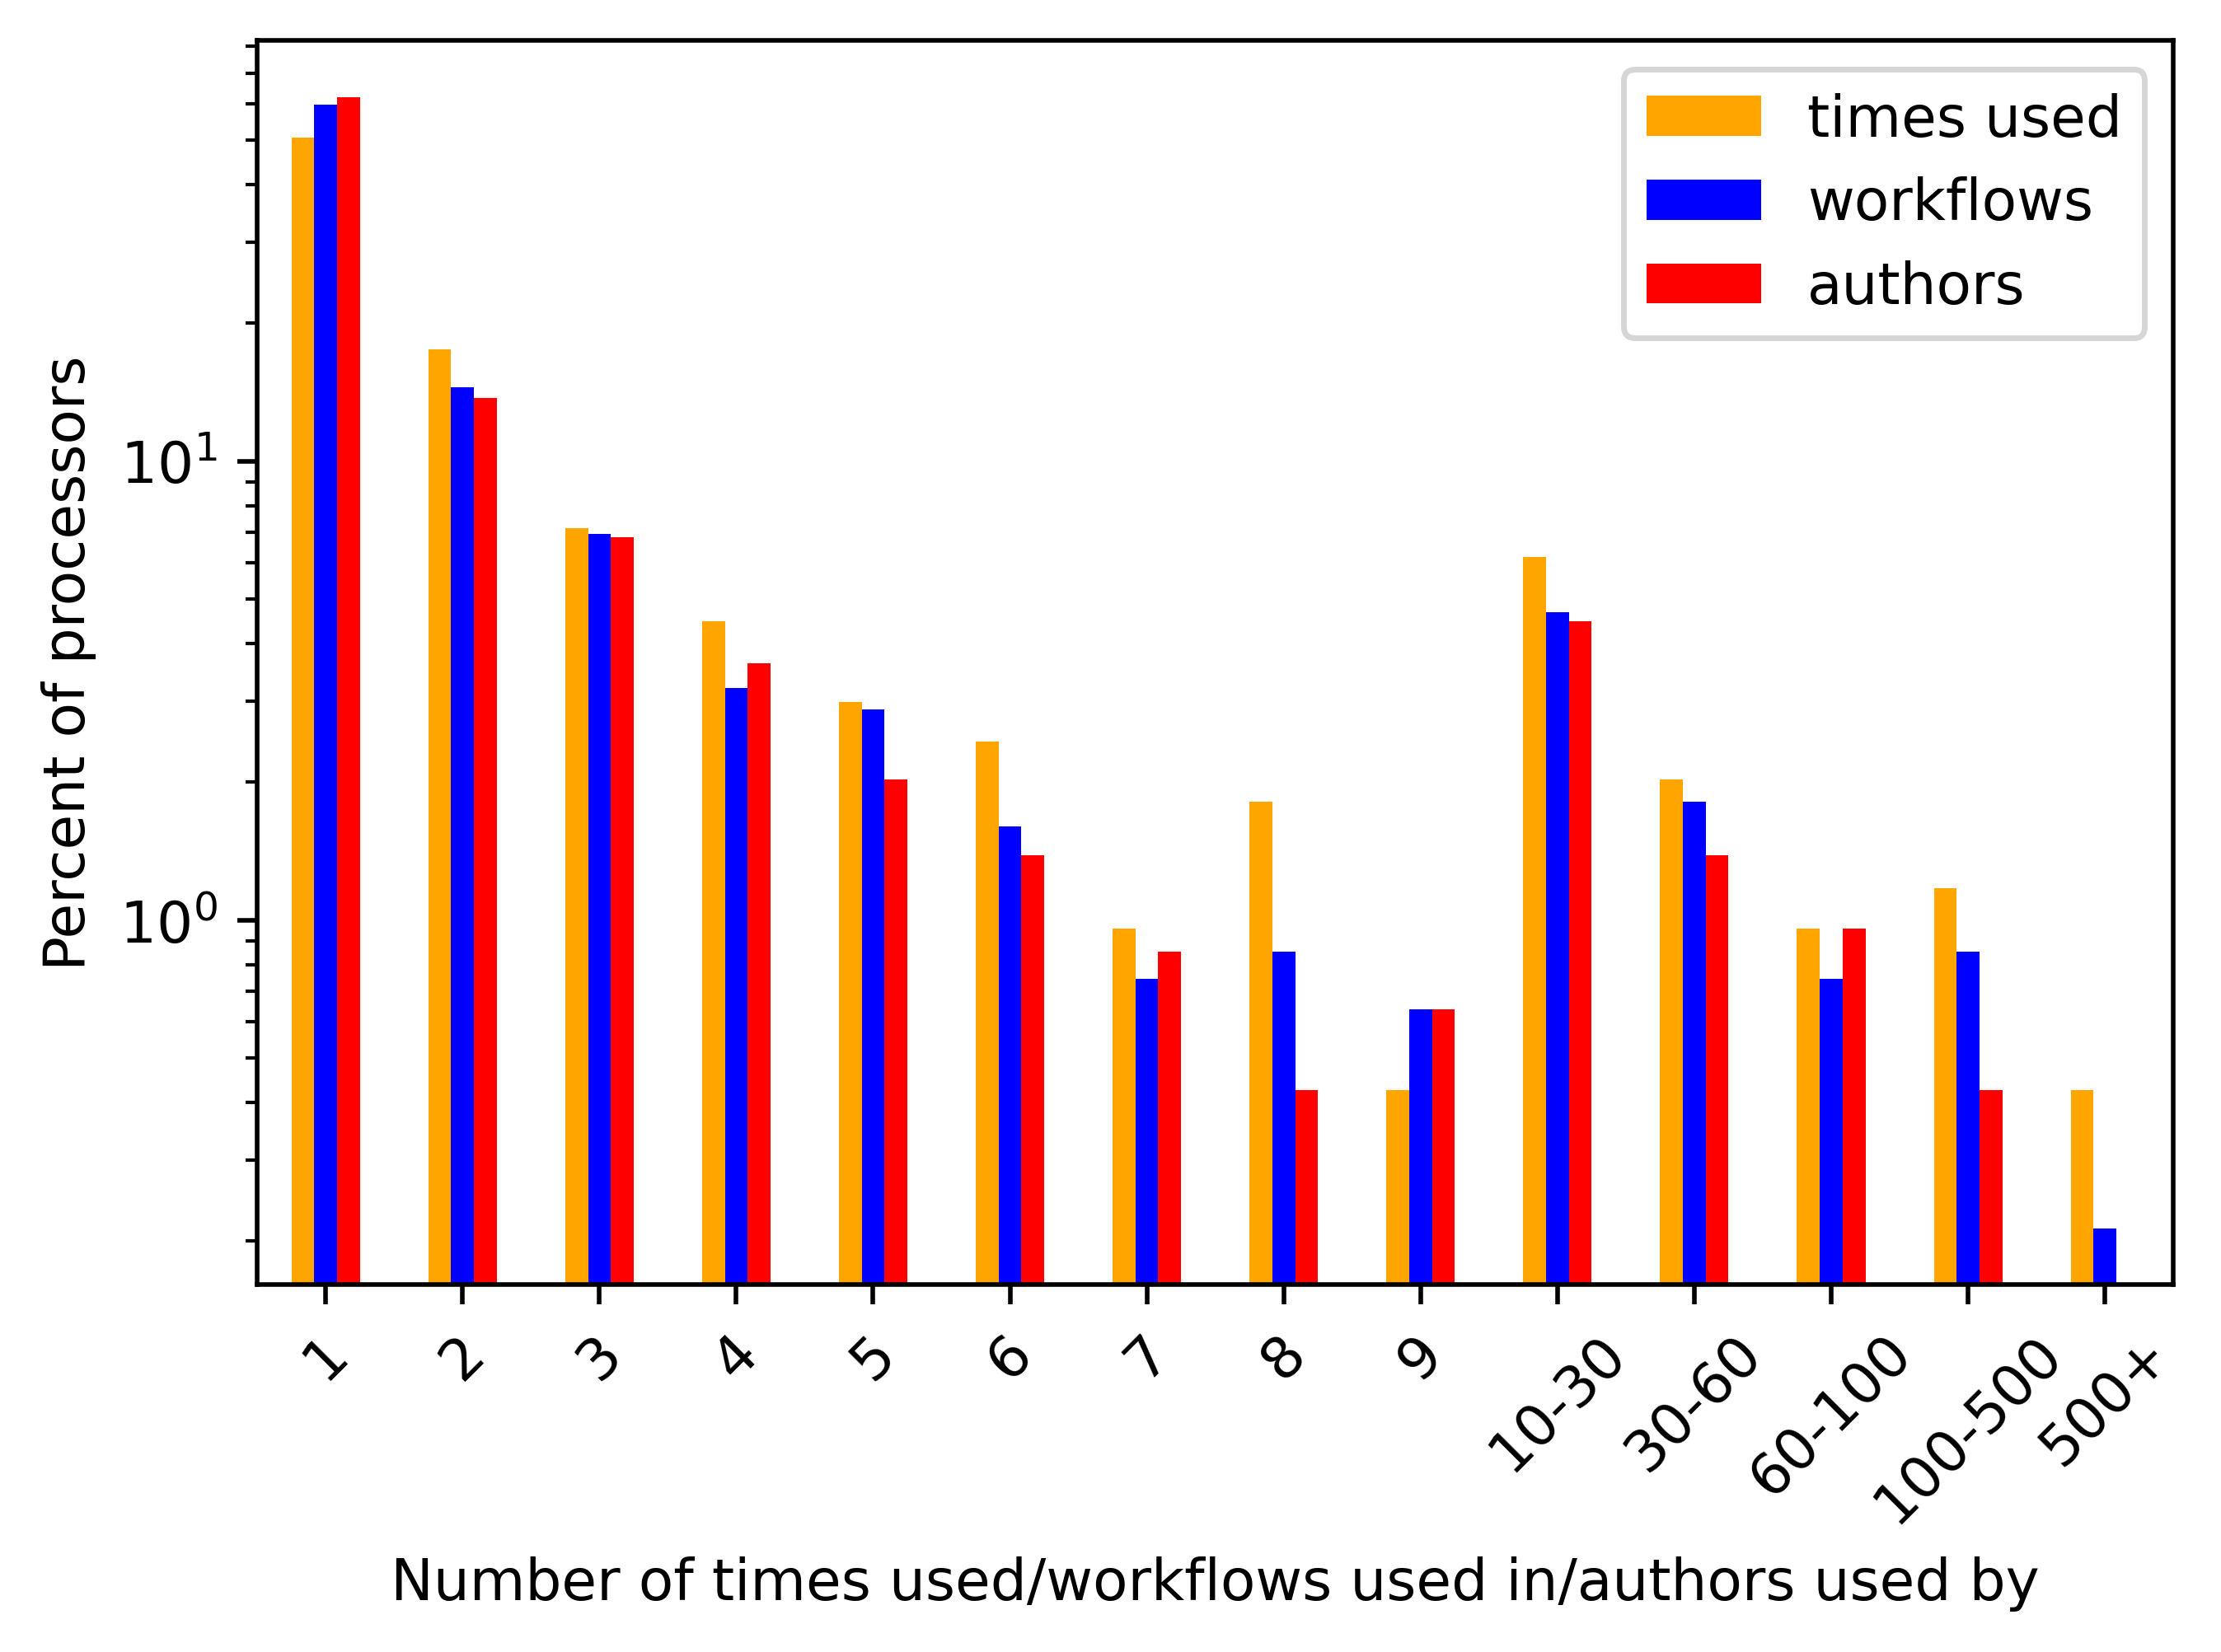

In [68]:
fig_4_nf_new = display_proportions_figure(df_groups_nf_new)

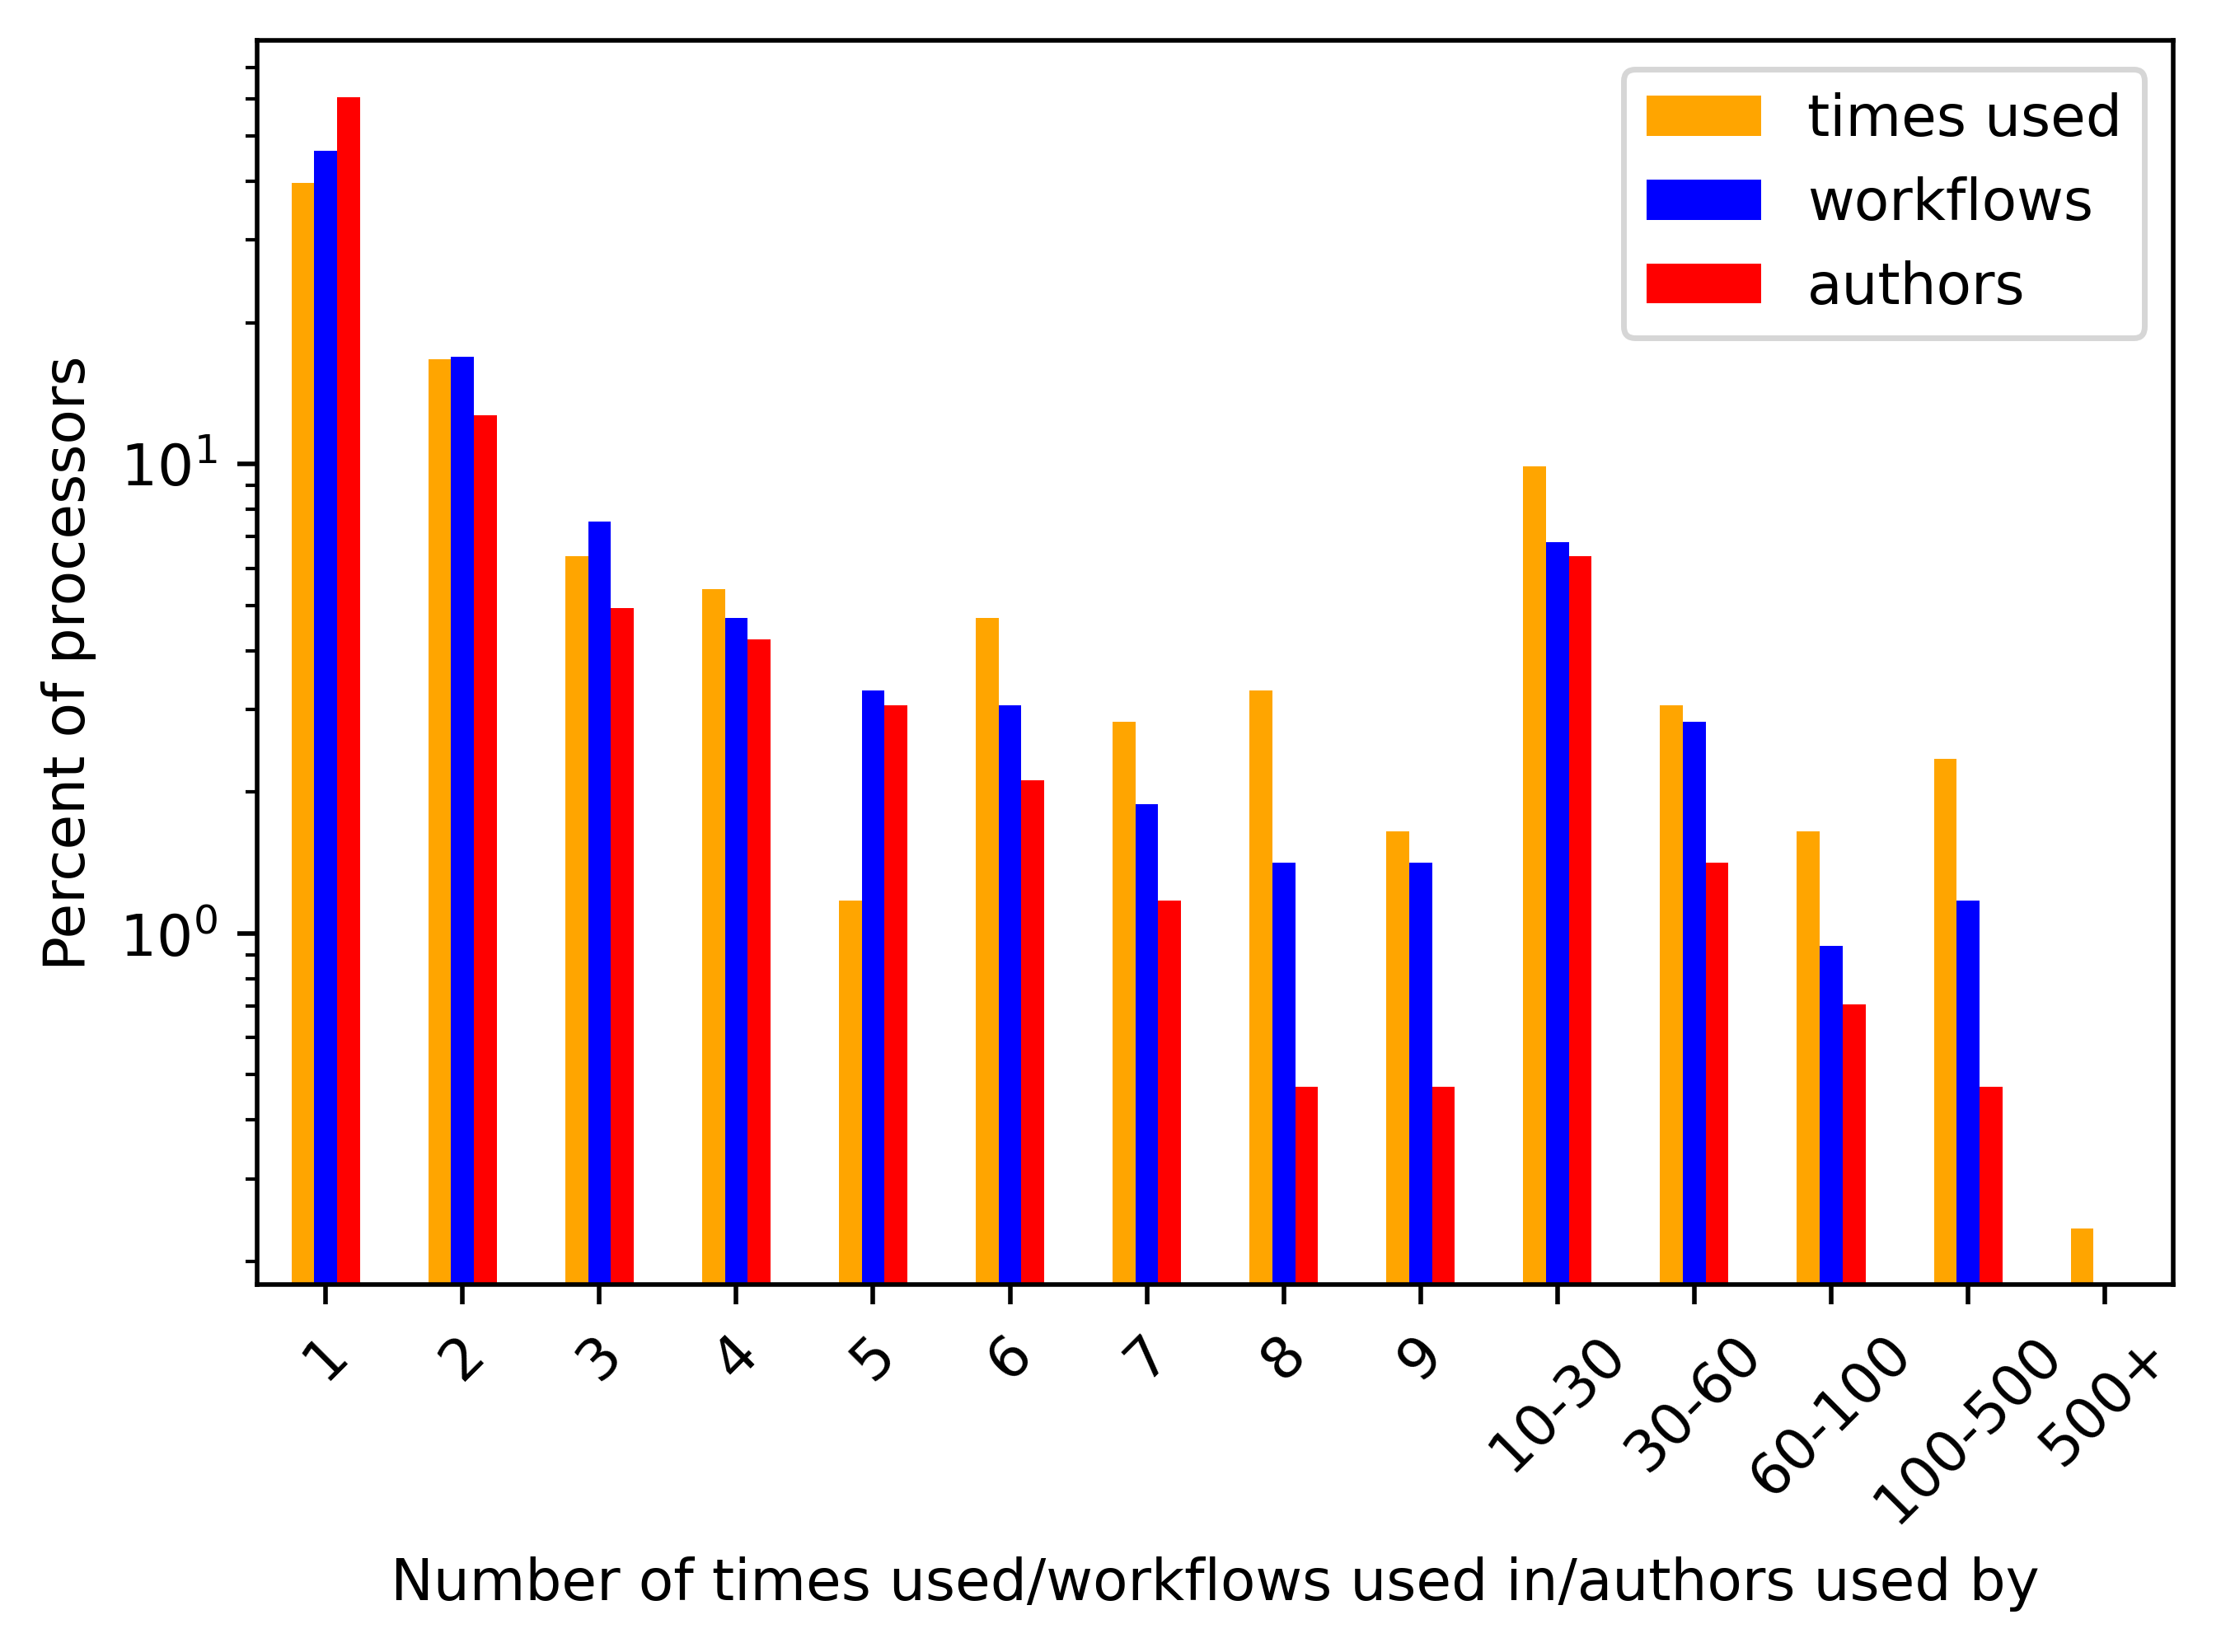

In [69]:
fig_4_snk_new = display_proportions_figure(df_groups_snk_new)

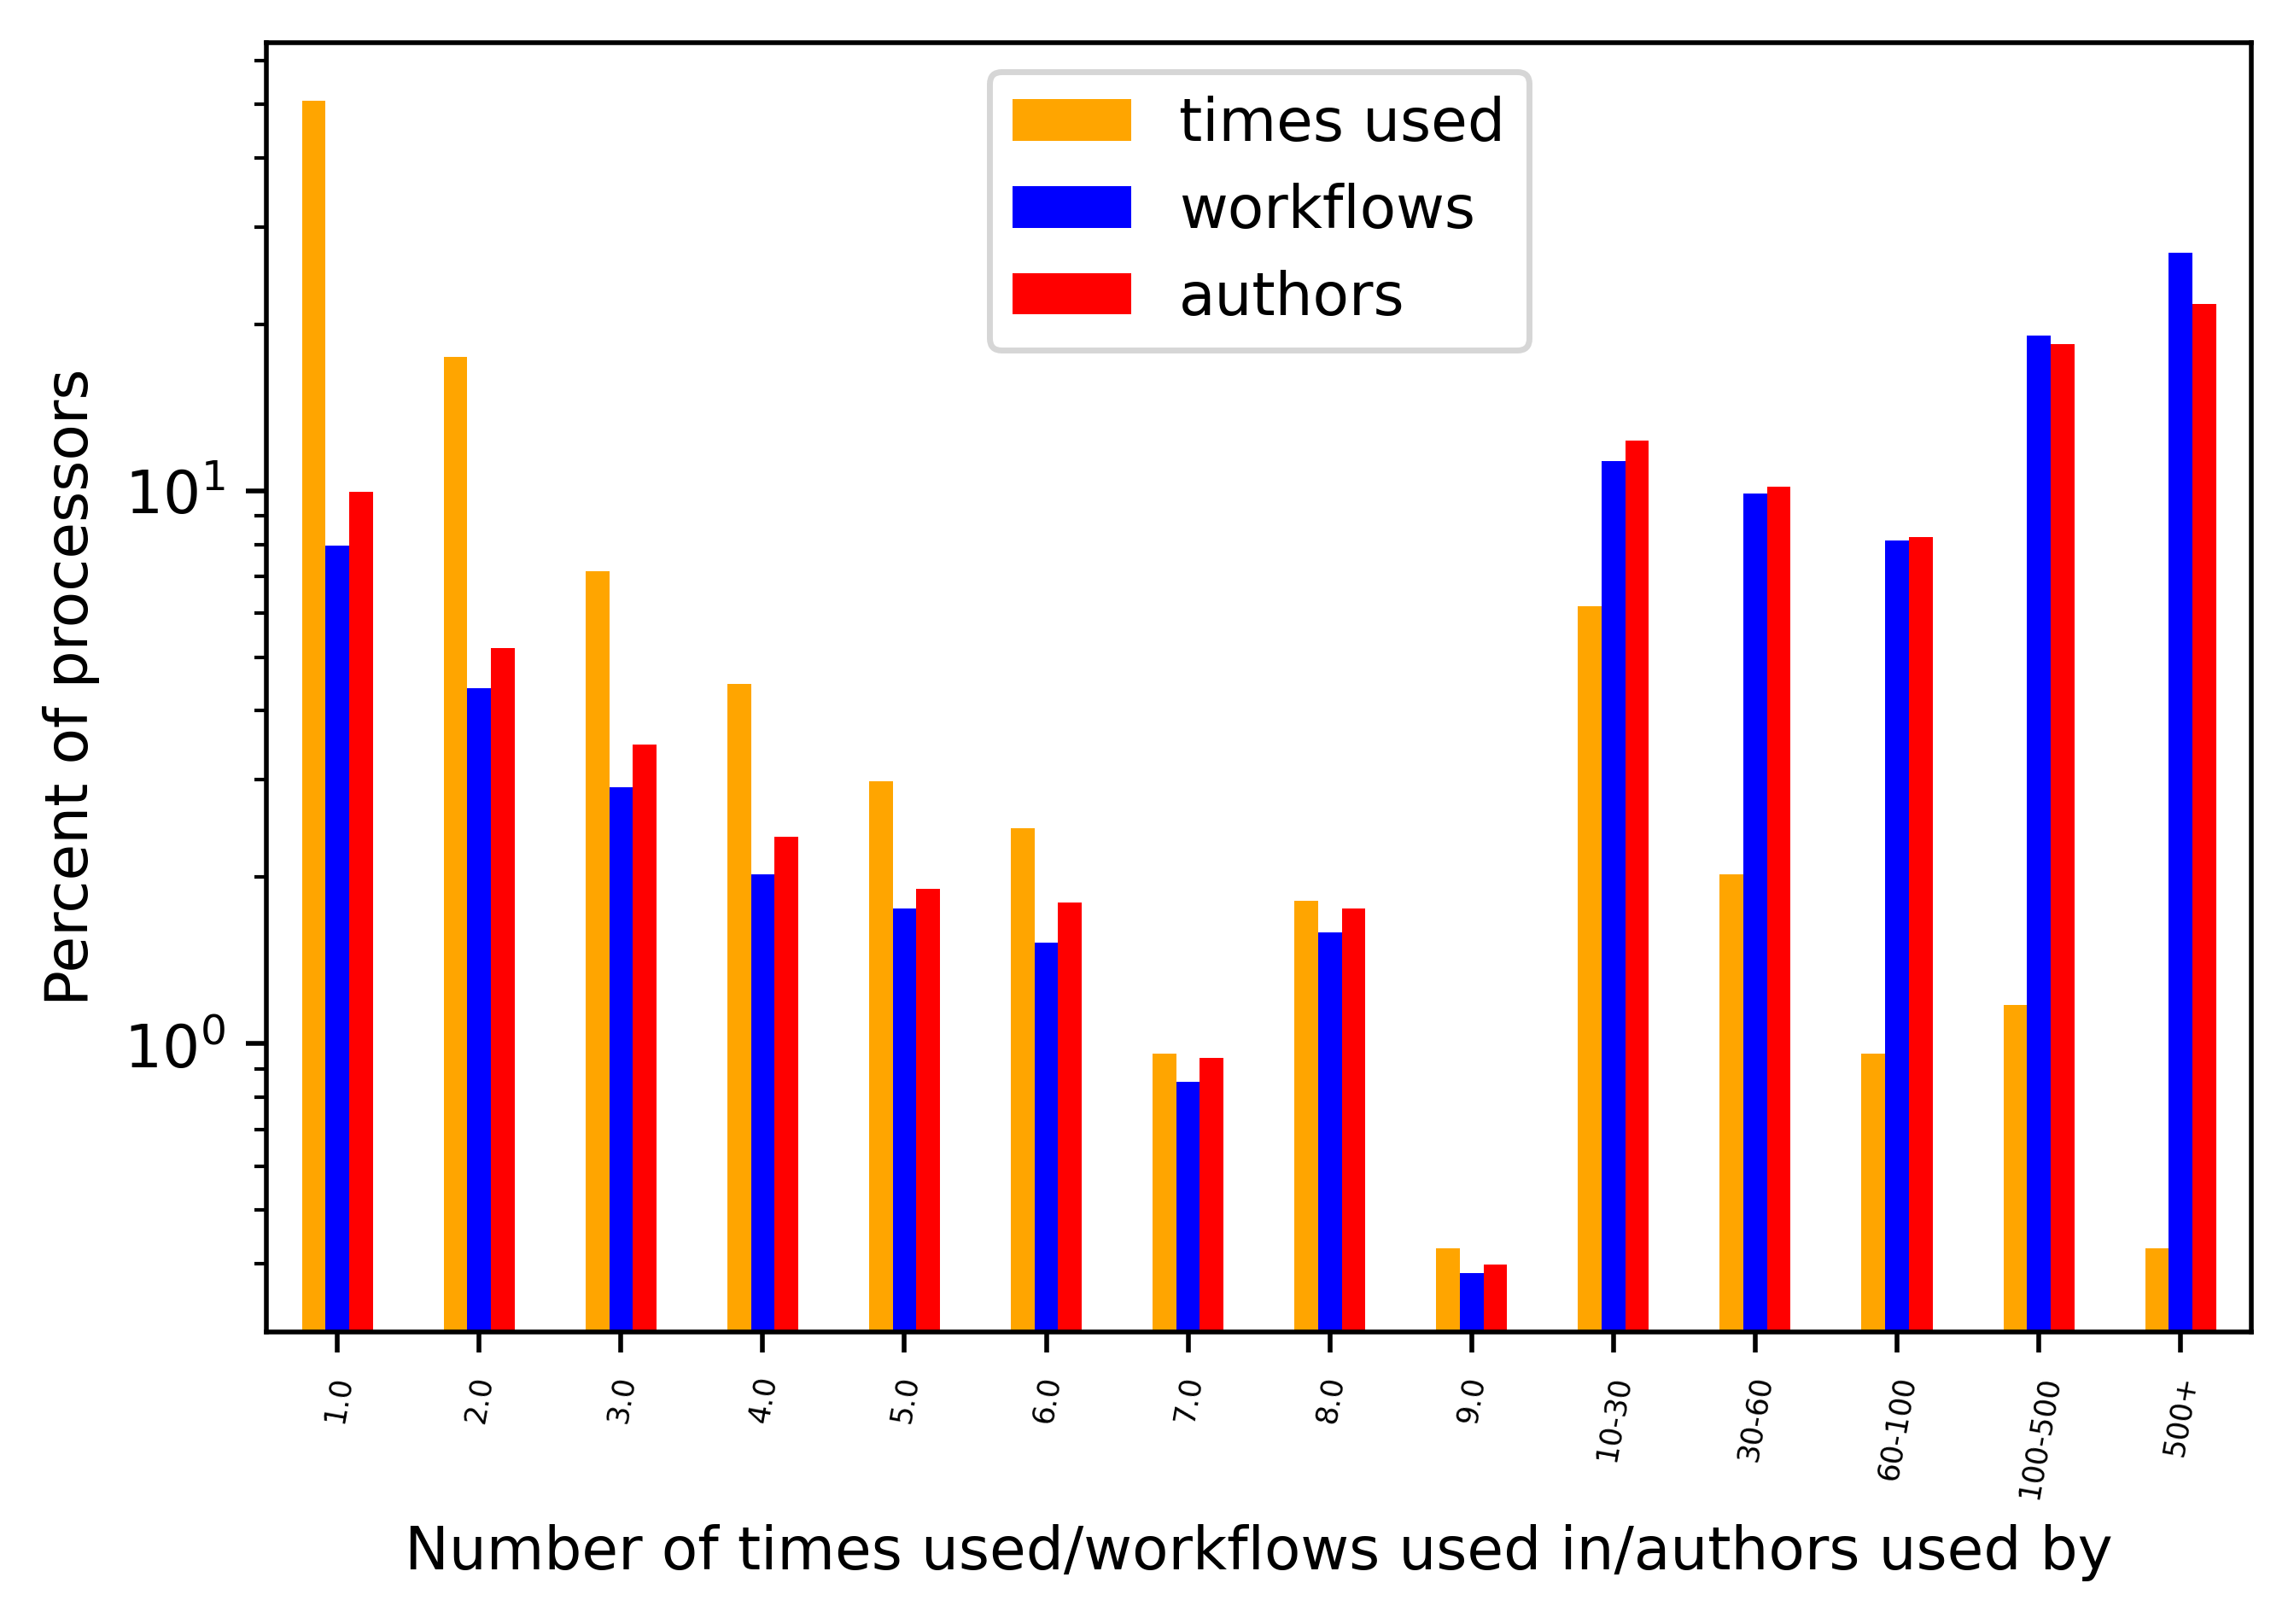

In [37]:
fig_4_nf = display_proportions_figure(df_groups_nf)

In [24]:
# top 5 most used processors nextflow
df_sim_nf.sort_values(by=["nb_reuse"], ascending = False).head(5)

,Unnamed: 0,list_contrib,list_own,list_wf,nb_contrib,nb_own,nb_reuse,nb_wf,tools
204,204,"{'alexandregilardet', 'jambler24', 'MSBradshaw...","{'icbi-lab', 'jambler24', 'zamanianlab', 'CRG-...","{'chipseq', 'nextflow_paired_reads_pipeline', ...",651.0,309.0,1369.0,460.0,['SAMtools']
730,730,"{'alexandregilardet', 'MSBradshaw', 'oxfordfun...","{'icbi-lab', 'jambler24', 'TDMedina', 'cbcrg',...","{'kraken2_biom_nf', 'chipseq', 'nf-core-mlst',...",602.0,351.0,656.0,528.0,['FastQC']
229,229,"{'alexandregilardet', 'jambler24', 'MSBradshaw...","{'erikrikarddaniel', 'heinzlab', 'icbi-lab', '...","{'kraken2_biom_nf', 'chipseq', 'nf-core-mlst',...",566.0,302.0,609.0,507.0,['MultiQC']
354,354,"{'J35P312', 'erikrikarddaniel', 'alexandregila...","{'loipf', 'rmoran7', 'zamanianlab', 'HugoManan...","{'nf-workflows', 'ngs_variant_calling', 'tuber...",241.0,80.0,565.0,119.0,['GATK']
341,341,"{'J35P312', 'erikrikarddaniel', 'alexandregila...","{'loipf', 'NYU-Molecular-Pathology', 'nebfield...","{'consensus-variant-caller', 'CePopulationGene...",275.0,98.0,343.0,148.0,['BCFtools']


In [179]:
def print_stats_wf(df_sim):
    print("Each processor is used "+str(df_sim["nb_reuse"].mean())+
      " times, in "+str(df_sim["nb_wf"].mean())+
     " wf and by "+str(df_sim["nb_own"].mean())+ " owners. \nMax of "+
         str(df_sim["nb_reuse"].max())+" usages, "+
         str(df_sim["nb_wf"].max())+" workflows, "+
         str(df_sim["nb_own"].max())+" owners.")

In [180]:
# Nextflow
print_stats_wf(df_sim_nf)

Each processor is used 10.289978678038379 times, in 6.3752665245202556 wf and by 5.09275053304904 owners. 
Max of 1369.0 usages, 528.0 workflows, 351.0 owners.


In [195]:
# top 5 most used processors snakemake
df_sim_snk.sort_values(by=["nb_reuse"], ascending = False).head(5)

,Unnamed: 0,list_contrib,list_own,list_wf,nb_contrib,nb_own,nb_reuse,nb_wf,tools
84,84,"{'jeongdo801', 'geparada', 'Oli4', 'z-sector',...","{'davidlevybooth', 'geparada', 'qfort', 'jeong...","{'montpetitlab/Aguilar_and_Paul_et_al_2020/2',...",340.0,248.0,1057.0,446.0,['SAMtools']
315,315,"{'csoeder', 'jfear', 'QiangTU', 'Oli4', 'klein...","{'csoeder', 'shenlab-sinai', 'BackofenLab', 'l...","{'bioxfu/iCLIP/2', 'bioxfu/ChIP-Seq/2', 'montp...",146.0,100.0,406.0,173.0,['BEDTools']
211,211,"{'rneher', 'lmoncla', 'cck42', 'jameshadfield'...","{'andersonbrito', 'grubaughlab', 'colejensen',...","{'blab/cartography/3', 'blab/cartography/5', '...",19.0,8.0,260.0,30.0,['Augur']
149,149,"{'wir963', 'kosolapova', 'mrbarbitoff', 'tsnor...","{'Xiuying', 'WilsonSayresLab', 'getzlab', 'Iur...","{'aryarm/str_ase/1', 'sfrenk/variant_calling_p...",30.0,23.0,242.0,48.0,['GATK']
326,326,"{'flying-sheep', 'Tina04021997', 'rbonneville'...","{'Tina04021997', 'tgac-vumc', 'lfdelzam', 'dav...","{'bioxfu/iCLIP/2', 'bioxfu/ChIP-Seq/2', 'ecalf...",157.0,115.0,232.0,167.0,['FastQC']


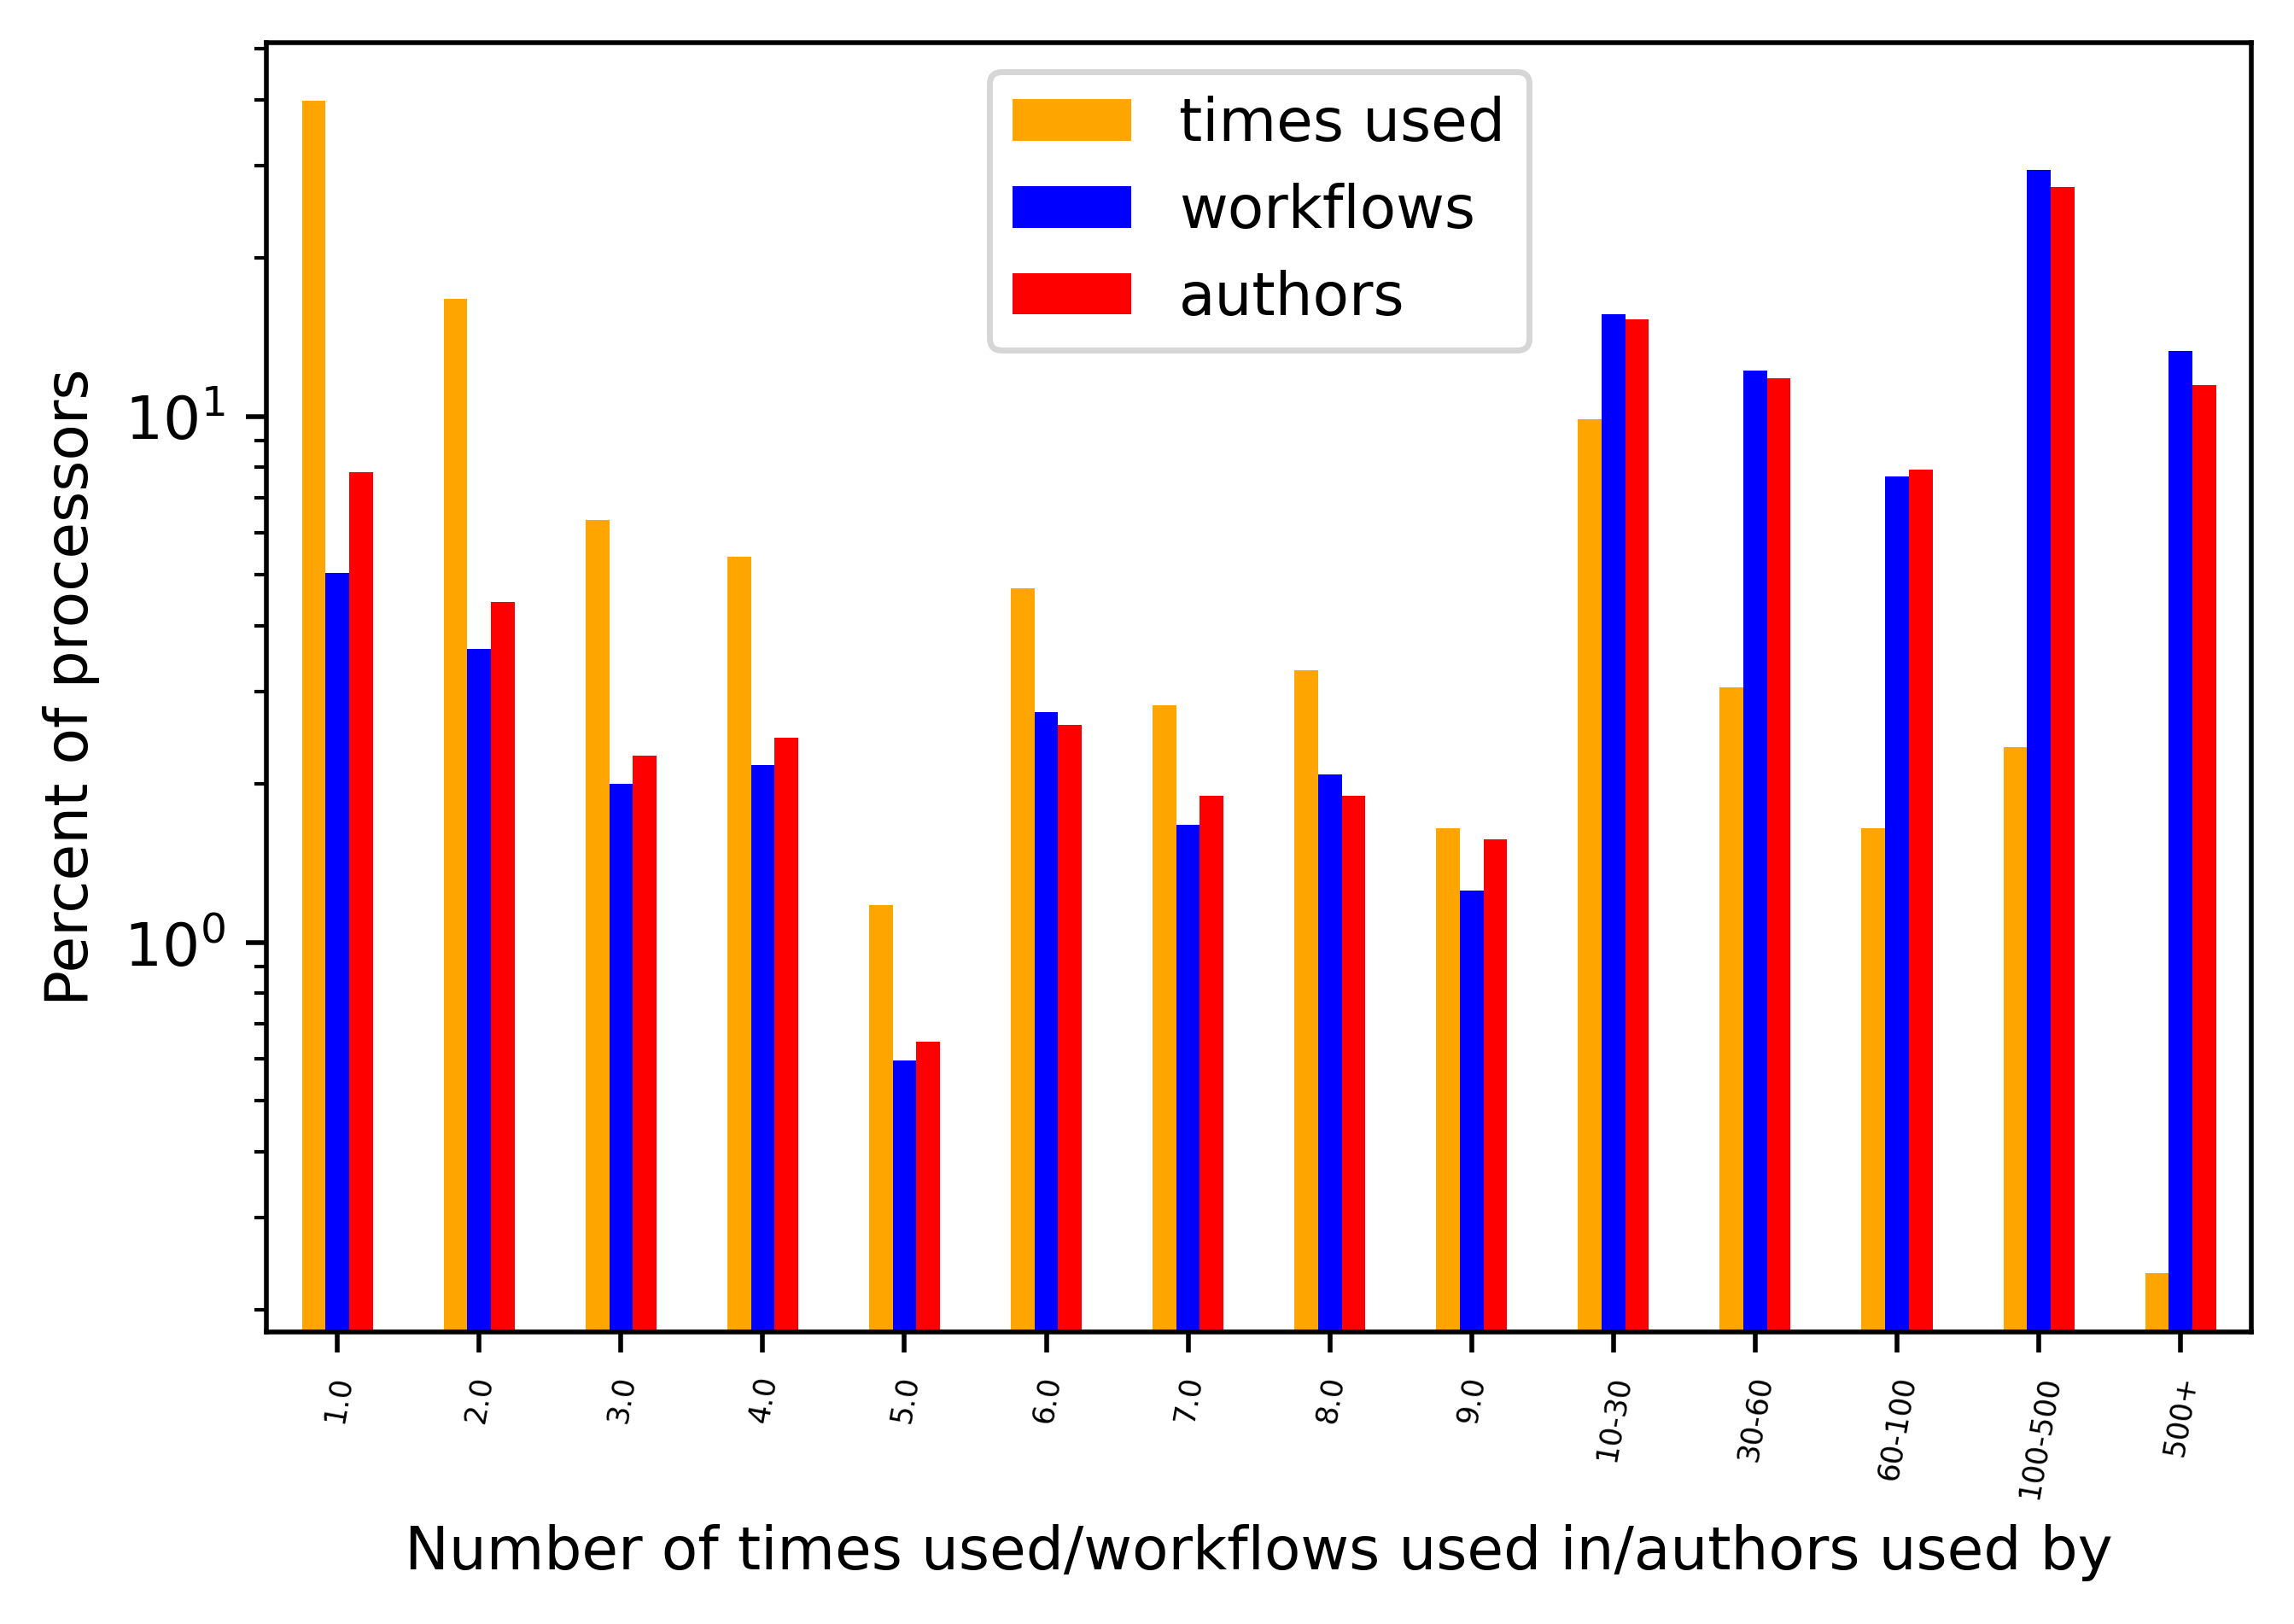

In [38]:
fig_4_snk = display_proportions_figure(df_groups_snk)

In [182]:
#snakemake
print_stats_wf(df_sim_snk)

Each processor is used 13.854117647058823 times, in 7.889411764705883 wf and by 5.087058823529412 owners. 
Max of 1057.0 usages, 446.0 workflows, 248.0 owners.


### Figure 4

In [42]:
#to recreate this, simply import :
df_sim_nf = pd.read_csv('csv/df_sim_nf.csv')
df_sim_snk = pd.read_csv('csv/df_sim_snk.csv')

In [43]:
def display_fig_stats_process(df_sim, nb_proc):
    df_sim = df_sim.sort_values(by=["nb_reuse"], ascending = False)
    df_sim_p = df_sim.head(nb_proc)
    ax = df_sim_p.plot(x="tools", y="nb_reuse", kind="bar", label = "times used", color = "orange")
    df_sim_p.plot(x="tools", y="nb_wf", ax=ax ,  kind="bar", color = "red", label = "workflows")
    df_sim_p.plot(x="tools", y="nb_own", ax=ax , kind="bar", color = "blue",  label = "authors")
    ax.set_title('Usage count of the '+str(nb_proc)+' most used processors') 
    plt.xticks([])
    #ax.set_xticklabels(l, rotation=80, size=5)
    ax.set_xlabel("Distinct processors")
    ax.set_ylabel("Nb of times used/wf used in/ owners")
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams['savefig.dpi'] = 500
    return ax

<AxesSubplot:title={'center':'Usage count of the 150 most used processors'}, xlabel='Distinct processors', ylabel='Nb of times used/wf used in/ owners'>

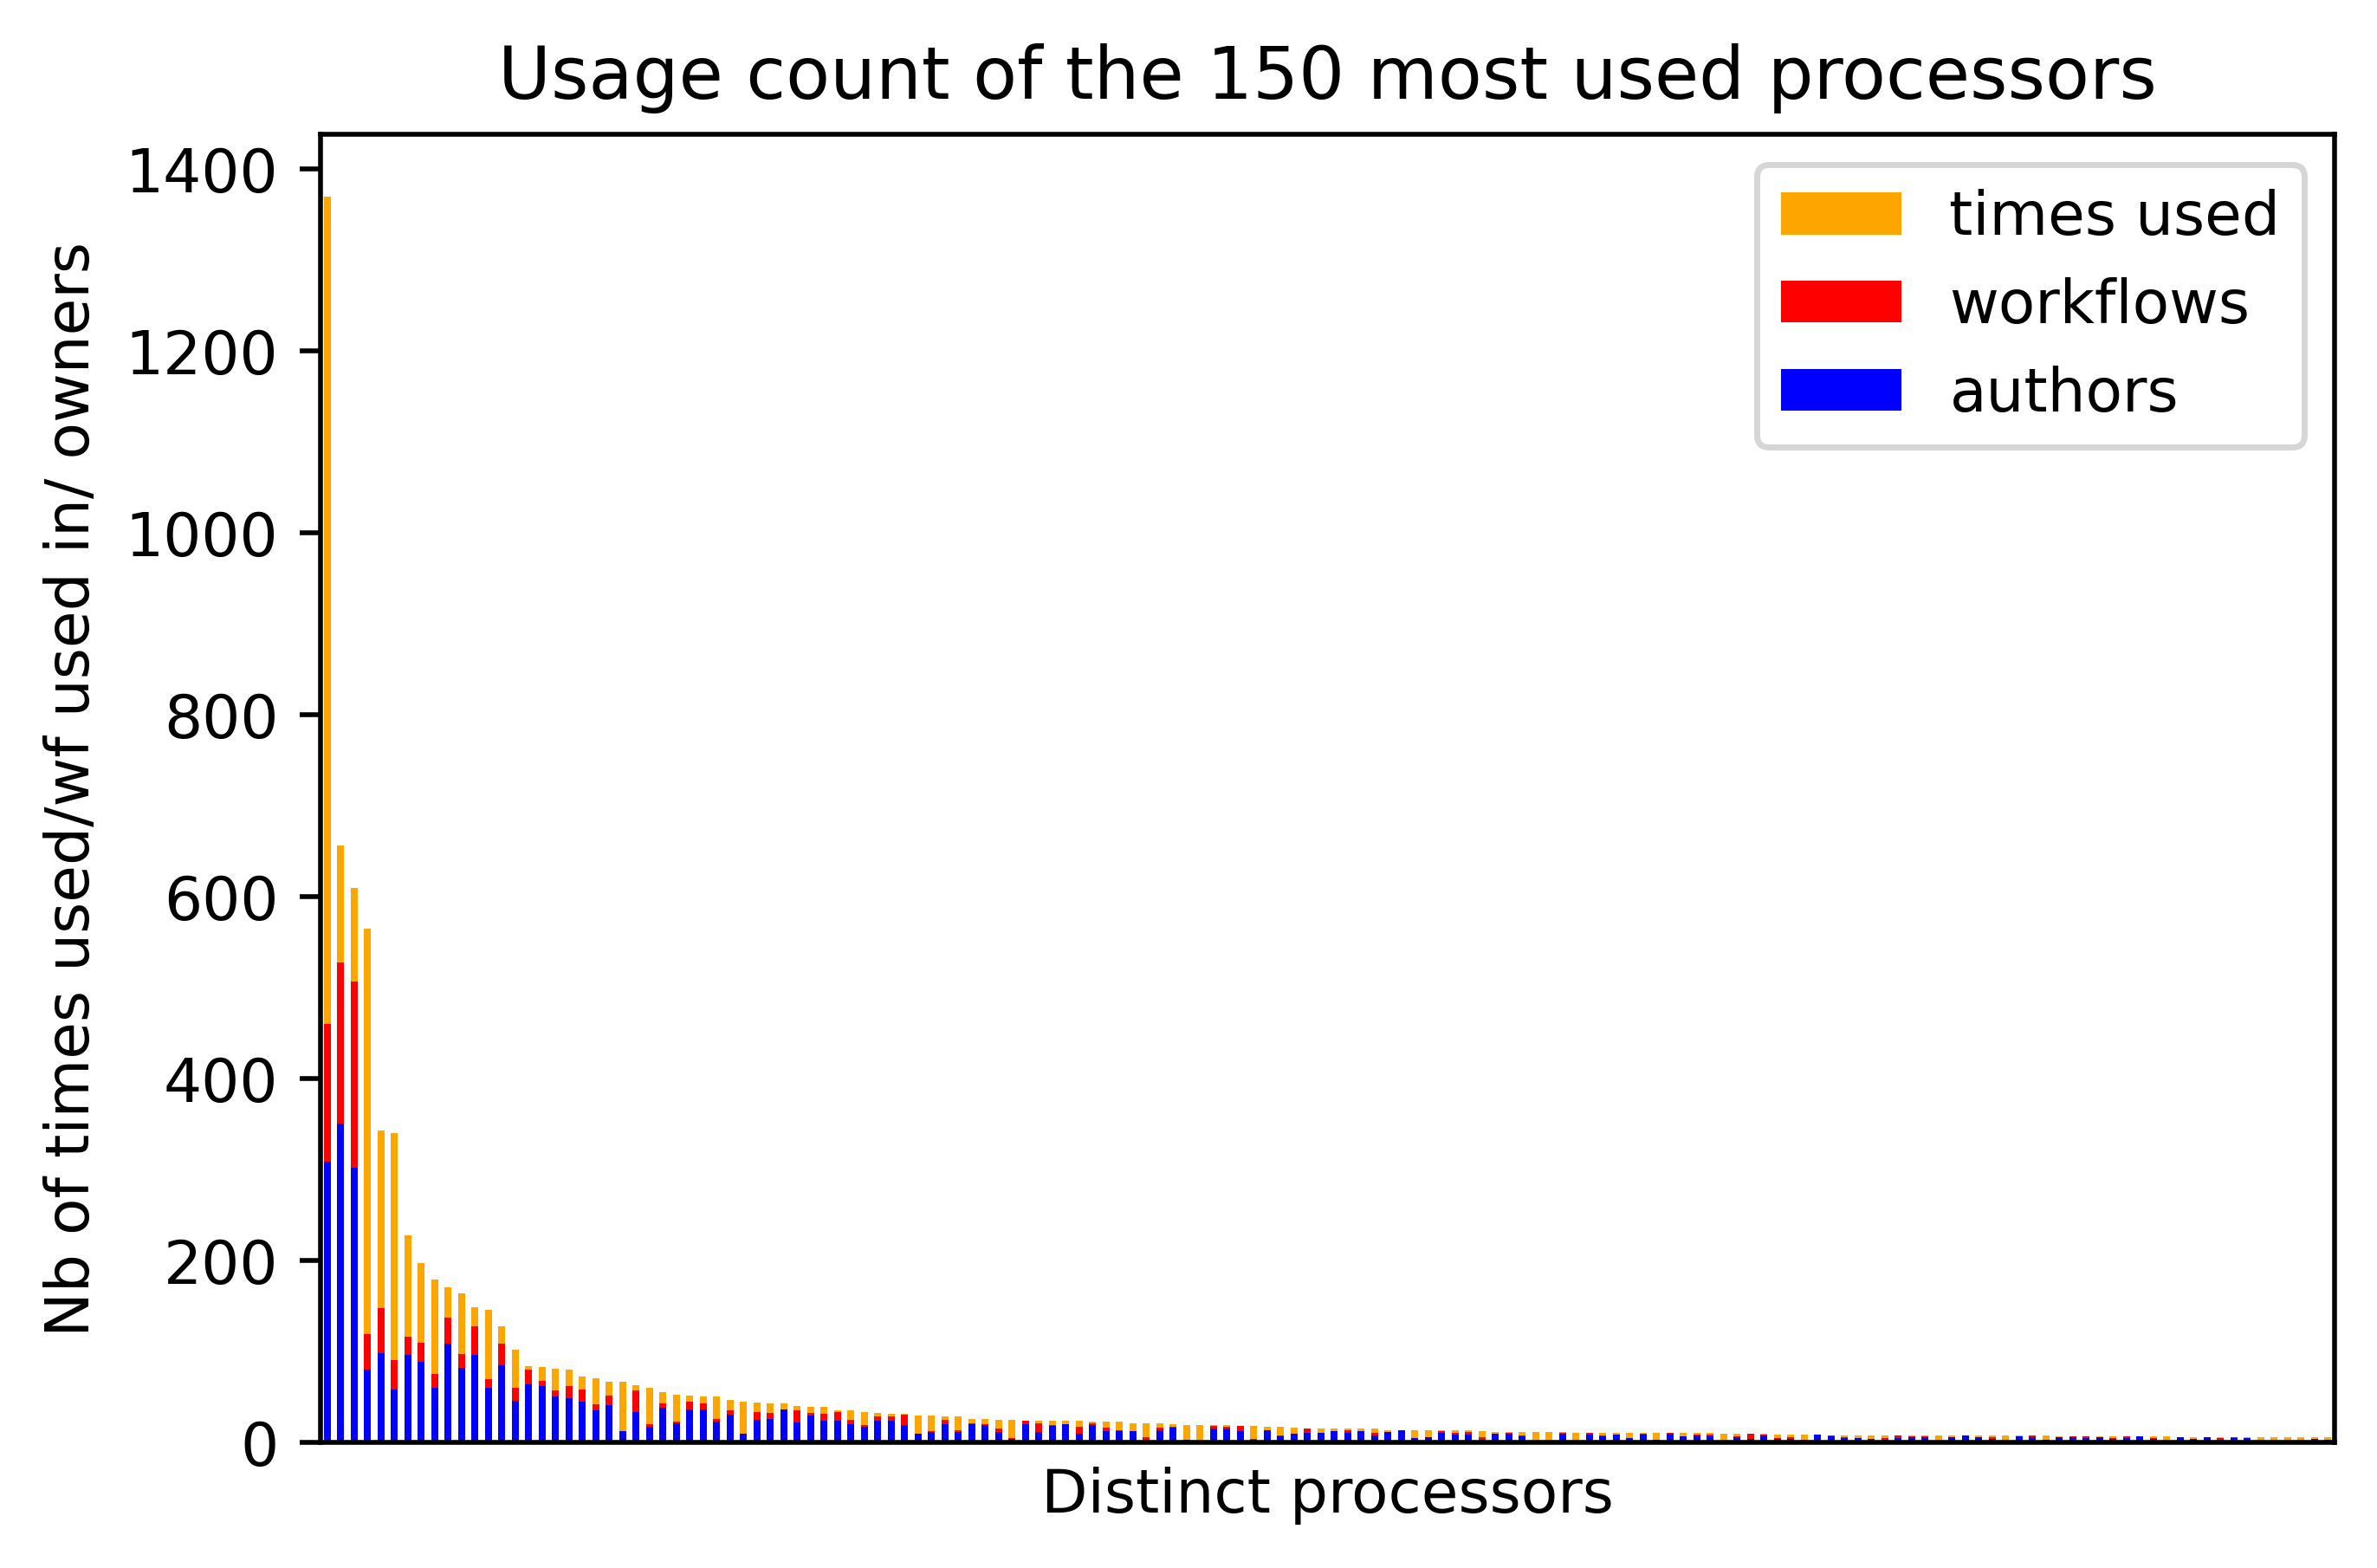

In [40]:
display_fig_stats_process(df_sim_nf, 150)

<AxesSubplot:title={'center':'Usage count of the 300 most used processors'}, xlabel='Distinct processors', ylabel='Nb of times used/wf used in/ owners'>

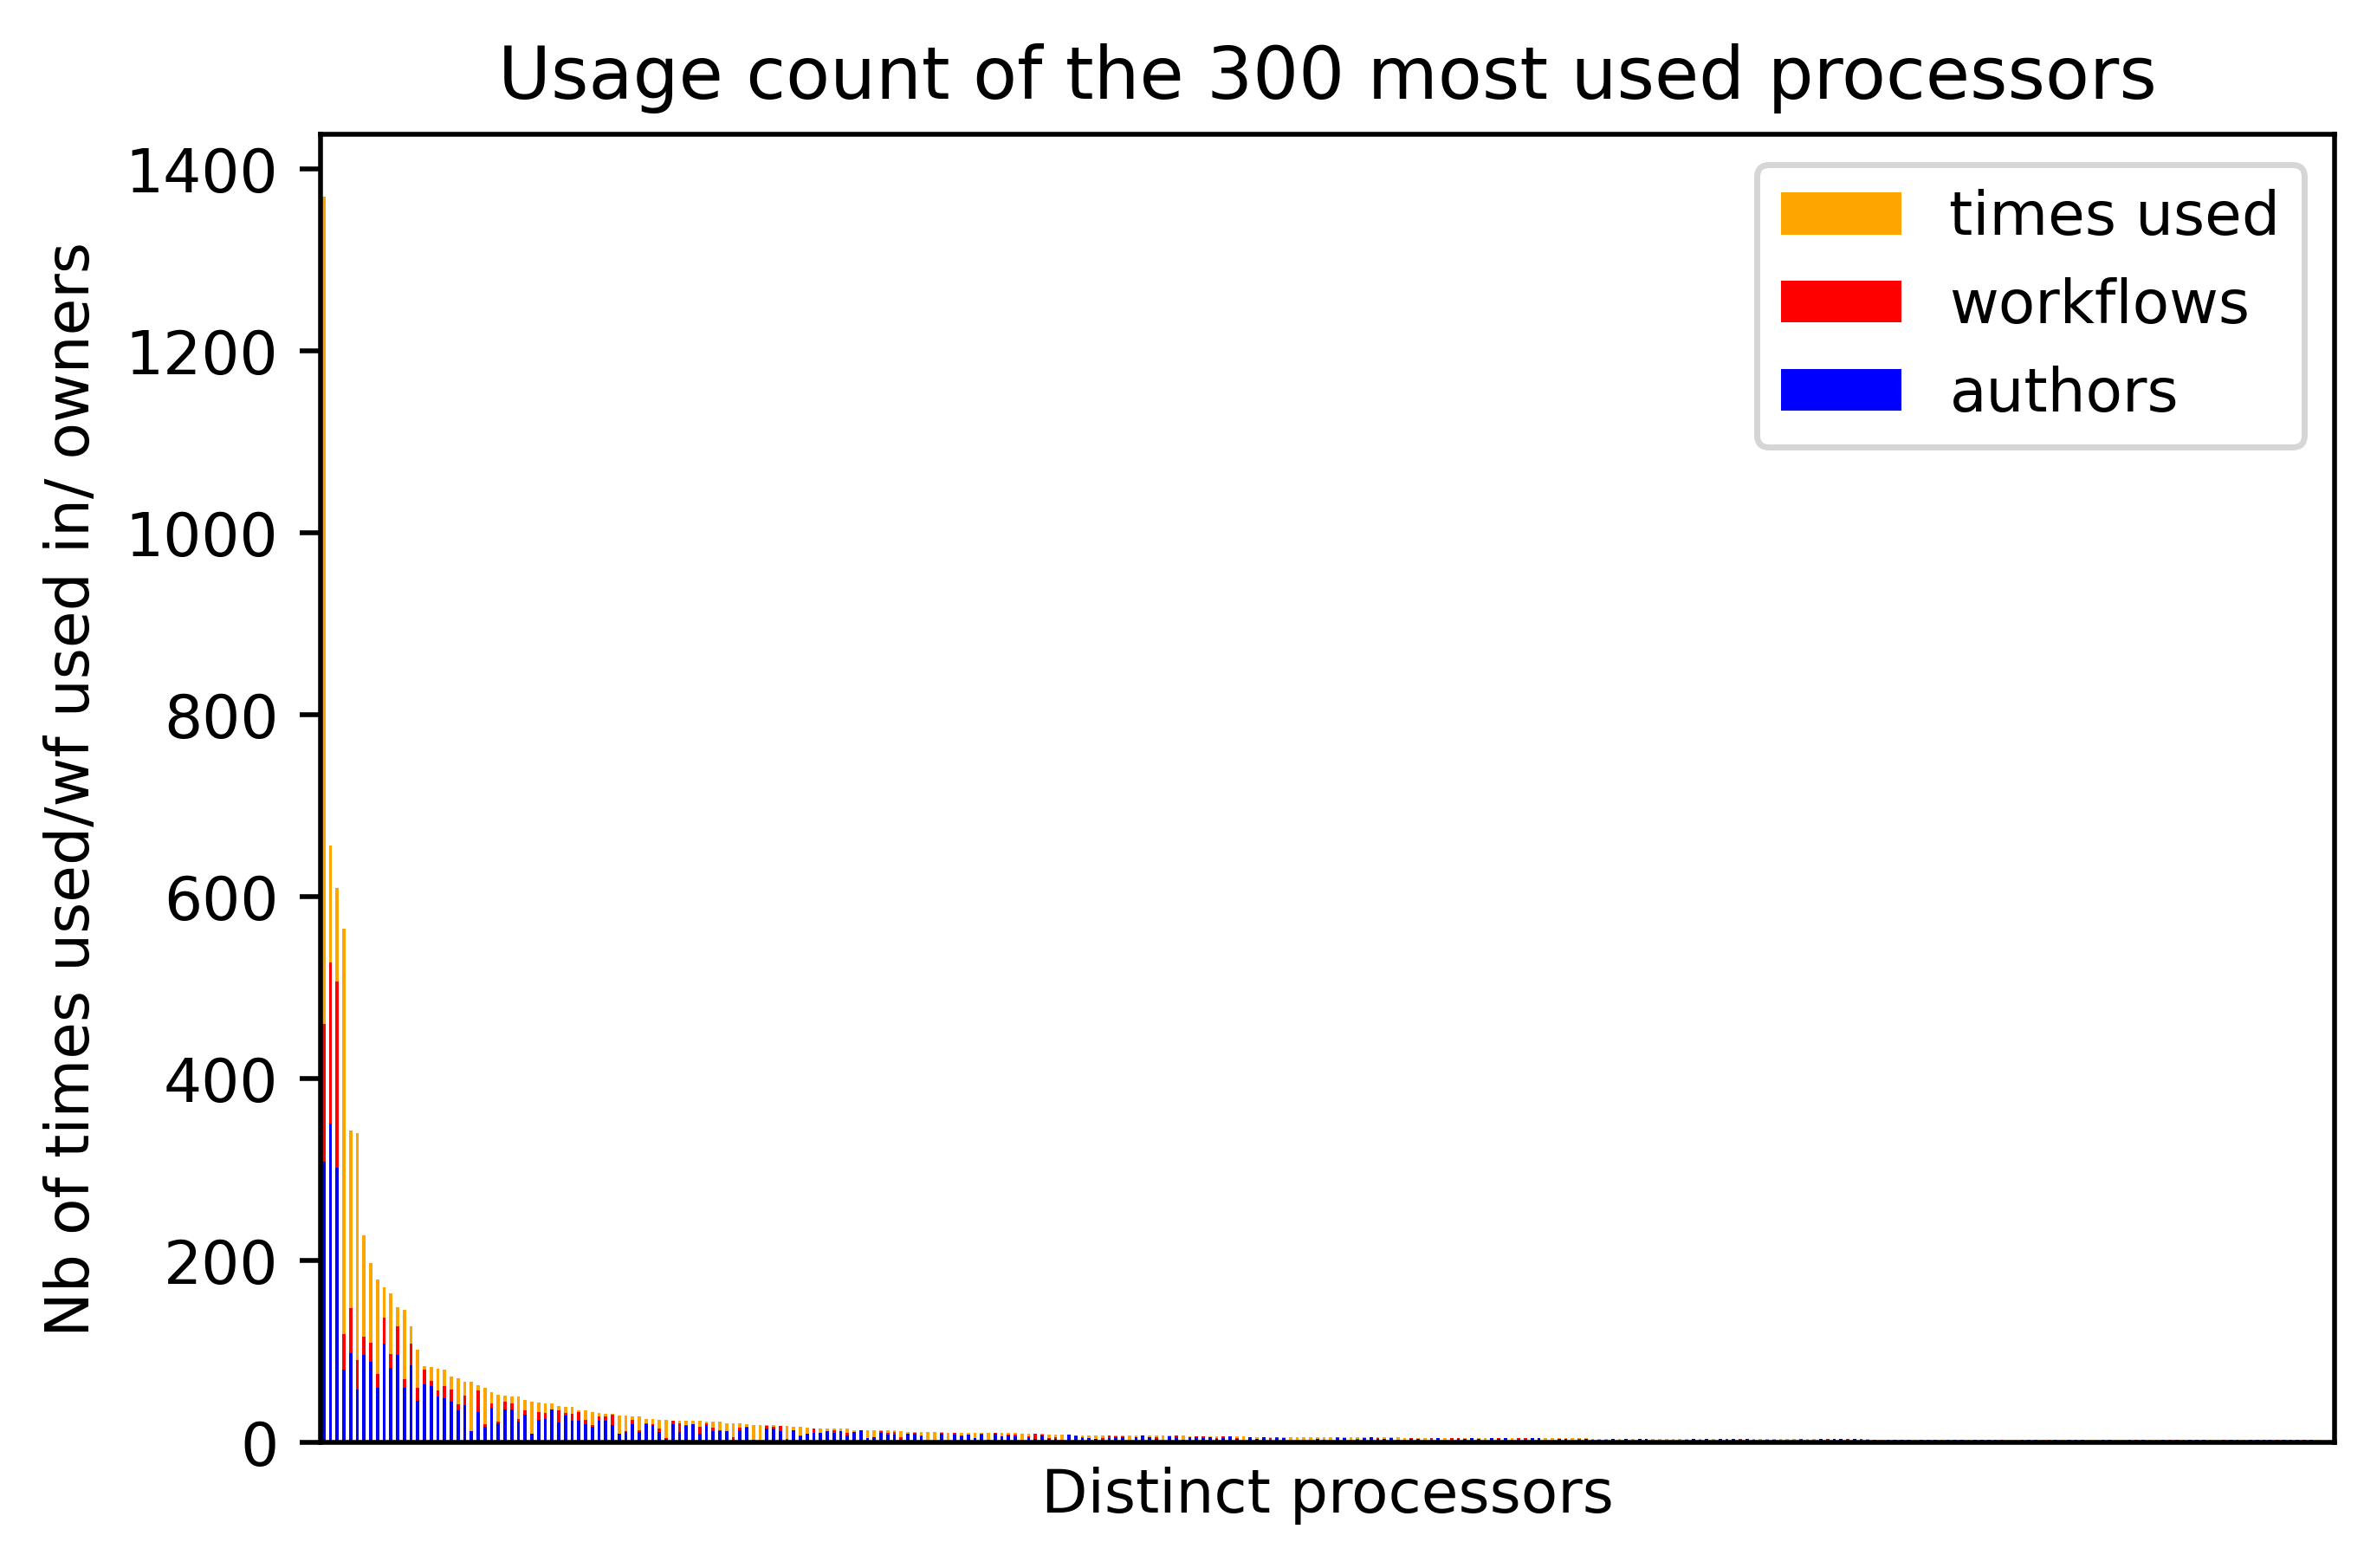

In [44]:
display_fig_stats_process(df_sim_nf, 300)

<AxesSubplot:title={'center':'Usage count of the 150 most used processors'}, xlabel='Distinct processors', ylabel='Nb of times used/wf used in/ owners'>

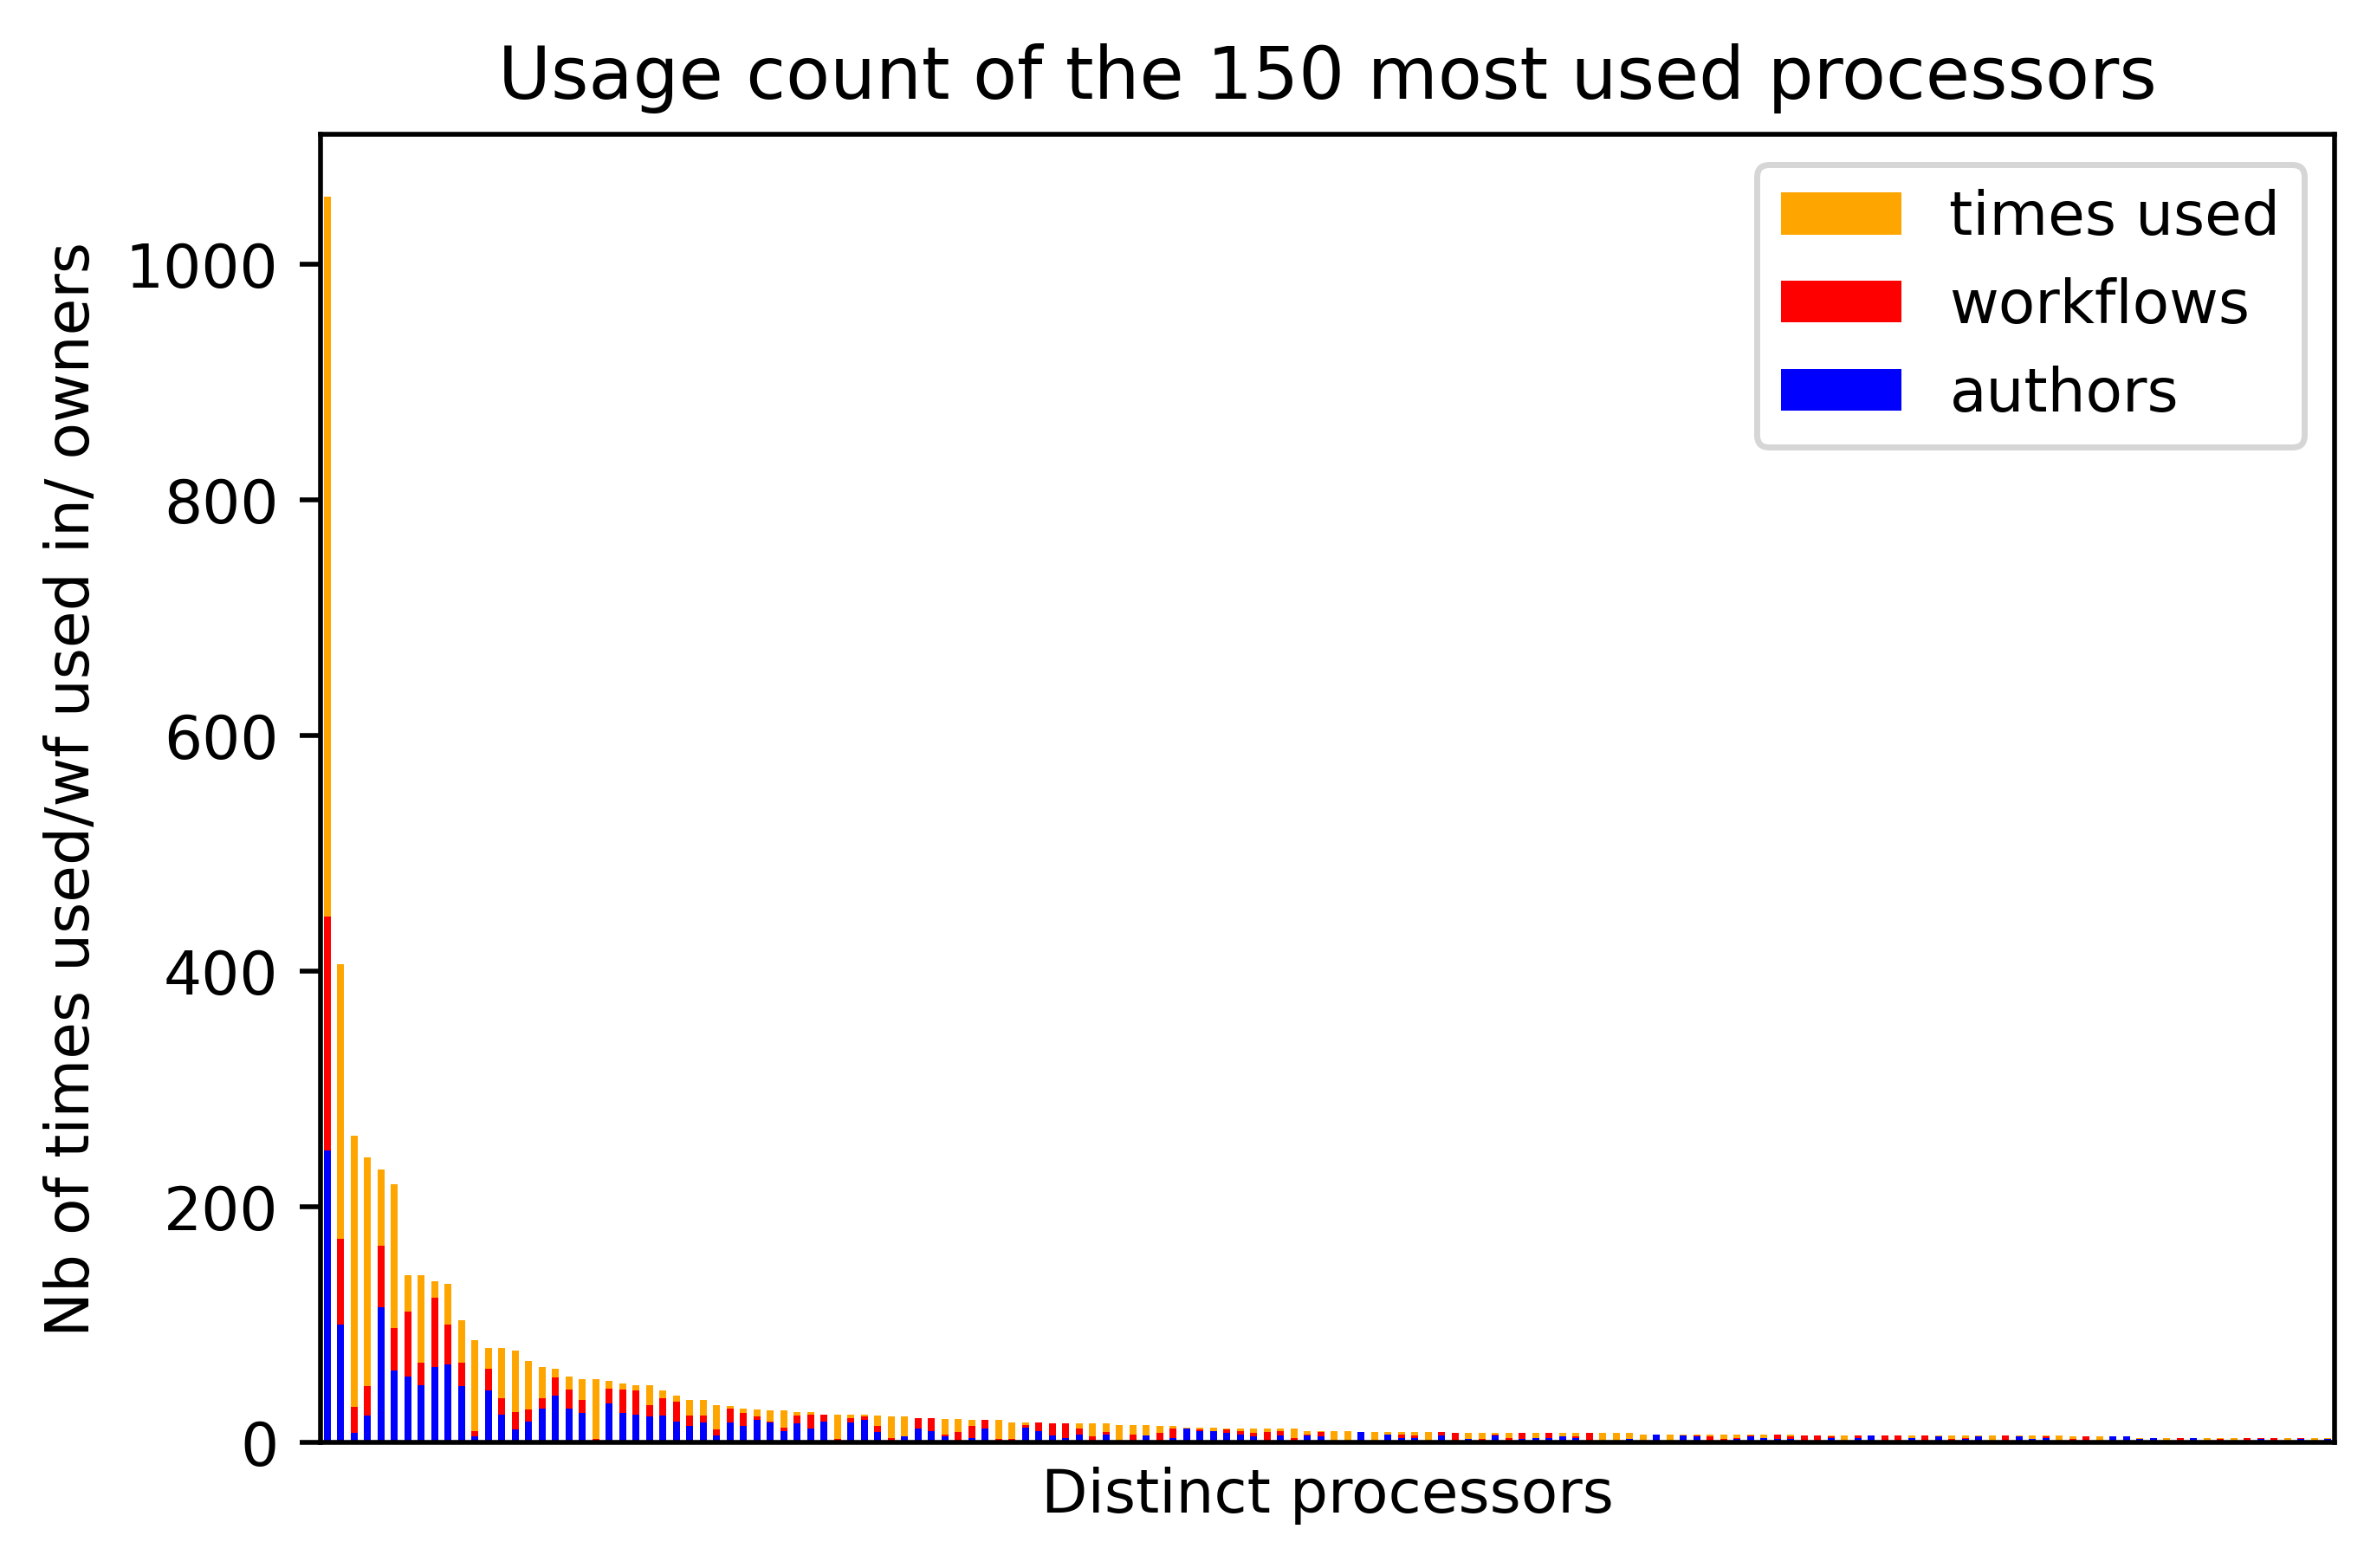

In [41]:
display_fig_stats_process(df_sim_snk, 150)

<AxesSubplot:title={'center':'Usage count of the 300 most used processors'}, xlabel='Distinct processors', ylabel='Nb of times used/wf used in/ owners'>

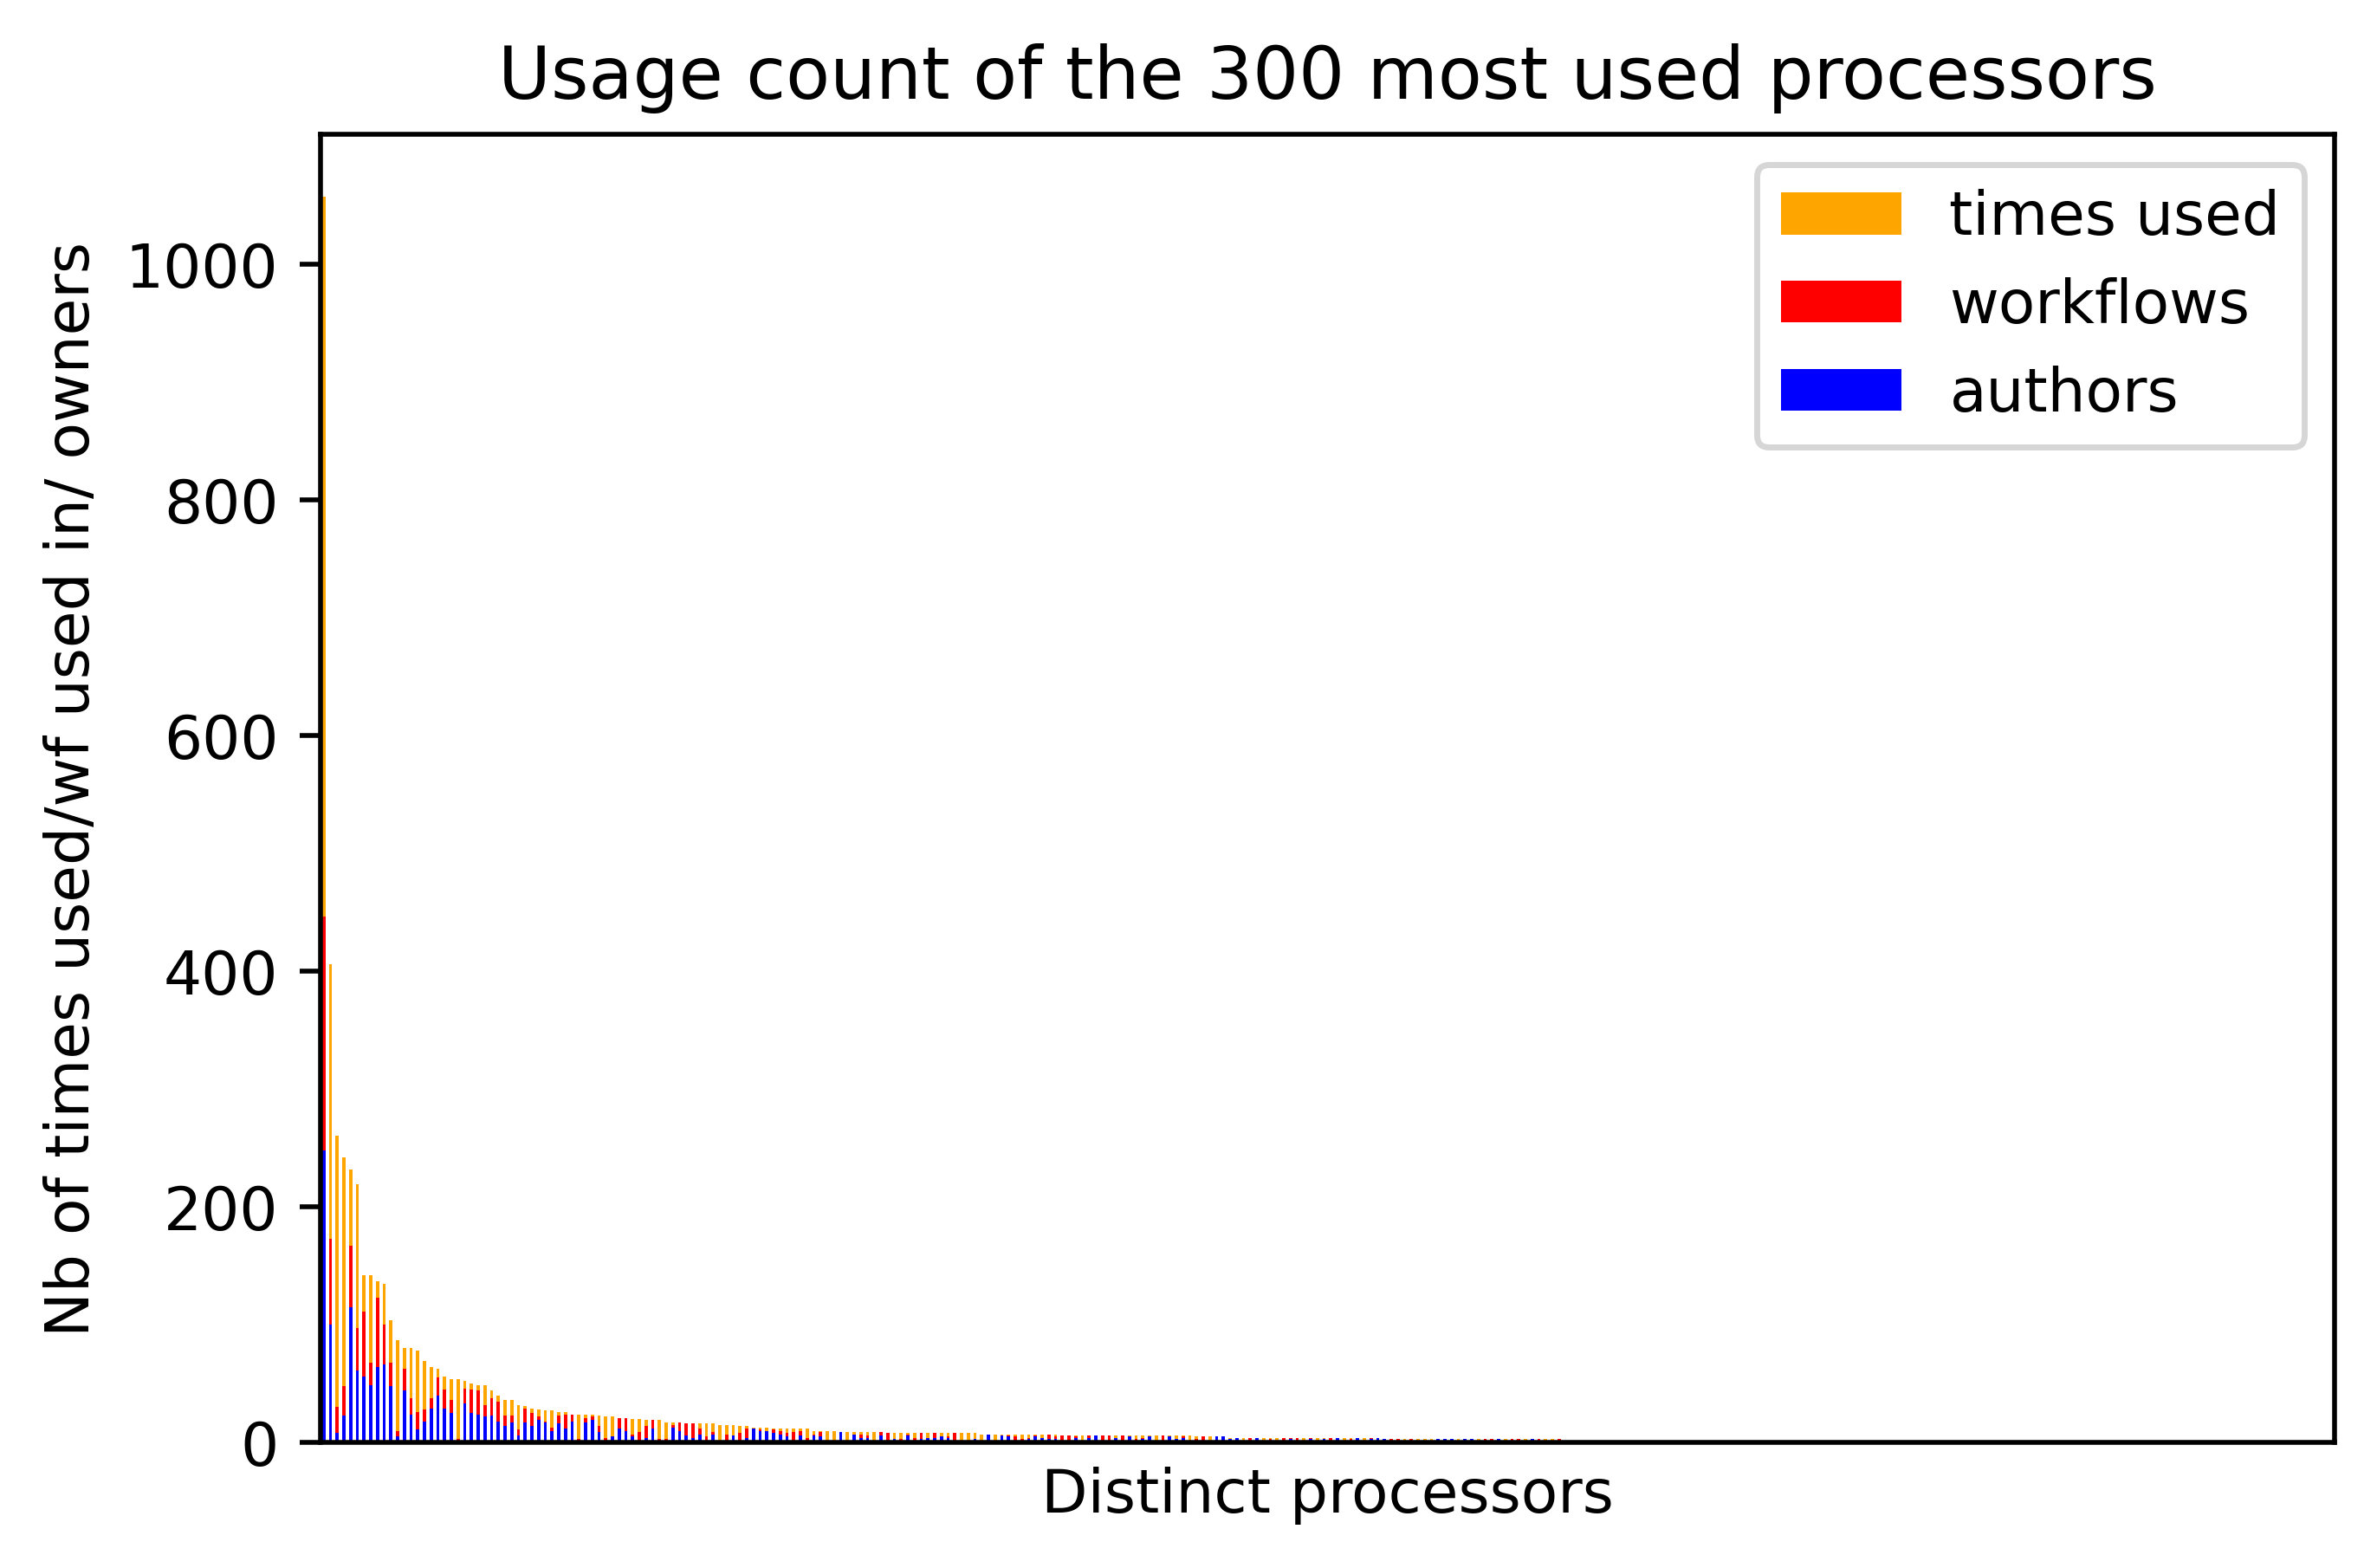

In [45]:
display_fig_stats_process(df_sim_snk, 300)

In [46]:
df_sim_snk.head()

,Unnamed: 0,list_contrib,list_own,list_wf,nb_contrib,nb_own,nb_reuse,nb_wf,tools
0,0,set(),{'mscharmann'},"{'mscharmann/sexdelim/2', 'mscharmann/sexdelim...",0.0,1.0,2.0,2.0,"['BWA', 'SAMtools', 'SAMtools', 'SAMtools', 's..."
1,1,"{'DarioS', 'xiaoyan-xu', 'wdeleeuw', 'kernco',...","{'davidlevybooth', 'xiaoyan-xu', 'kernco', 'Lo...","{'penglbio/RNA_Seq/1', 'kernco/deg_pipeline/1'...",15.0,16.0,26.0,23.0,['htseqcount']
2,2,"{'fburic', 'franciscozorrilla', 'sevance', 'el...","{'franciscozorrilla', 'Finn-Lab', 'skinmicrobi...","{'franciscozorrilla/metaGEM/2', 'skinmicrobiom...",13.0,5.0,12.0,8.0,['dRep']
3,3,{'arvestad'},{'arvestad'},"{'arvestad/accuracy_in_prime/3', 'arvestad/acc...",1.0,1.0,2.0,2.0,['CS-PSeq-Gen']
4,4,"{'vodkatad', 'samleenz'}","{'vodkatad', 'samleenz'}","{'vodkatad/snakegatk/14', 'samleenz/variant-ca...",2.0,2.0,2.0,2.0,['Platypus']


In [15]:
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_wf"]>=2])/len(df_sim_nf)))

nf : 0.40191897654584224


In [23]:
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>=9])))
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>=9])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>=9])/len(df_sim_nf)))
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>=9])/len(df_sim_snk)))

nf : 85
snk : 46
nf : 0.0906183368869936
snk : 0.10823529411764705


In [22]:
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_wf"]>=9])))
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_wf"]>=9])))

nf : 89
snk : 62


In [17]:
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_wf"]>=9])/len(df_sim_nf)))
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_wf"]>=9])/len(df_sim_snk)))

nf : 0.09488272921108742
snk : 0.14588235294117646


In [8]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_reuse"]>=300])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_reuse"]>=300])))

snk : 2
nf : 6


In [9]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_reuse"]>=100])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_reuse"]>=100])))

snk : 11
nf : 15


In [82]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_reuse"]>80])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_reuse"]>80])))

snk : 12
nf : 18


In [81]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_reuse"]>50])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_reuse"]>50])))

snk : 22
nf : 30


In [83]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_reuse"]>20])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_reuse"]>20])))

snk : 46
nf : 63


In [10]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_reuse"]>=9])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_reuse"]>=9])))

snk : 84
nf : 112


In [19]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_reuse"]>=9])/len(df_sim_snk)))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_reuse"]>=9])/len(df_sim_nf)))

snk : 0.1976470588235294
nf : 0.11940298507462686


In [11]:
reuse_9_snk = df_sim_snk.loc[df_sim_snk["nb_reuse"]>=9]
reuse_9_nf = df_sim_nf.loc[df_sim_nf["nb_reuse"]>=9]

In [12]:
reuse_9_nf.head(1)

,Unnamed: 0,list_contrib,list_own,list_wf,nb_contrib,nb_own,nb_reuse,nb_wf,tools
7,7,"{'phelelani', 'lucacozzuto', 'melferink', 'ale...","{'phelelani', 'noelnamai', 'luslab', 'cmatKhan...","{'allele_specific_RNAseq', 'nf-rnaSeqCount', '...",20.0,9.0,9.0,9.0,['htseqcount']


In [13]:
wf_reuse_9_snk = []
auth_reuse_9_snk = []
for liste_wf in reuse_9_snk["list_wf"]:
    for el in liste_wf:
        wf_reuse_9_snk.append(el)
        
for liste_auth in reuse_9_snk["list_own"]:
    for el in liste_auth:
        auth_reuse_9_snk.append(el)
        
print("nb wf tot snk : "+str(len(set(wf_reuse_9_snk))))
print("nb auth tot snk : "+str(len(set(auth_reuse_9_snk))))

nb wf tot snk : 71
nb auth tot snk : 67


In [14]:
wf_reuse_9_nf = []
auth_reuse_9_nf = []
for liste_wf in reuse_9_nf["list_wf"]:
    for el in liste_wf:
        wf_reuse_9_nf.append(el)
        
for liste_auth in reuse_9_nf["list_own"]:
    for el in liste_auth:
        auth_reuse_9_nf.append(el)
        
print("nb wf tot nf : "+str(len(set(wf_reuse_9_nf))))
print("nb auth tot nf : "+str(len(set(auth_reuse_9_nf))))

nb wf tot nf : 70
nb auth tot nf : 69


In [85]:
print("snk :"+str(len(df_sim_snk)))
print("nf :"+str(len(df_sim_nf)))

snk :425
nf :938


In [96]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>9])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>9])))

snk : 44
nf : 79


In [89]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>5])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>5])))

snk : 62
nf : 110


In [88]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>10])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>10])))

snk : 39
nf : 71


In [87]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>20])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>20])))

snk : 21
nf : 38


In [50]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>50])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>50])))

snk : 7
nf : 17


In [51]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_own"]>100])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_own"]>100])))

snk : 2
nf : 4


In [52]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_contrib"]>100])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_contrib"]>100])))

snk : 4
nf : 110


In [53]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_contrib"]>50])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_contrib"]>50])))

snk : 10
nf : 116


In [91]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_contrib"]>20])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_contrib"]>20])))

snk : 32
nf : 144


In [92]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_contrib"]>10])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_contrib"]>10])))

snk : 56
nf : 199


In [93]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_contrib"]>5])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_contrib"]>5])))

snk : 92
nf : 267


In [97]:
print("snk : "+str(len(df_sim_snk.loc[df_sim_snk["nb_contrib"]>9])))
print("nf : "+str(len(df_sim_nf.loc[df_sim_nf["nb_contrib"]>9])))

snk : 58
nf : 200


In [57]:
print("max contrib snk : "+str(df_sim_snk["nb_contrib"].max()))
print("mean contrib snk : "+str(df_sim_snk["nb_contrib"].mean()))
print("max contrib nf : "+str(df_sim_nf["nb_contrib"].max()))
print("mean contrib nf : "+str(df_sim_nf["nb_contrib"].mean()))

max contrib snk : 340.0
mean contrib snk : 7.169411764705882
max contrib nf : 651.0
mean contrib nf : 21.927505330490405


In [86]:
print("max own snk : "+str(df_sim_snk["nb_own"].max()))
print("mean own snk : "+str(df_sim_snk["nb_own"].mean()))
print("max own nf : "+str(df_sim_nf["nb_own"].max()))
print("mean own nf : "+str(df_sim_nf["nb_own"].mean()))

max own snk : 248.0
mean own snk : 5.087058823529412
max own nf : 351.0
mean own nf : 5.09275053304904


array([<AxesSubplot:title={'center':'amount of contrib per snk proc'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'amount of own per snk proc'}, ylabel='Frequency'>],
      dtype=object)

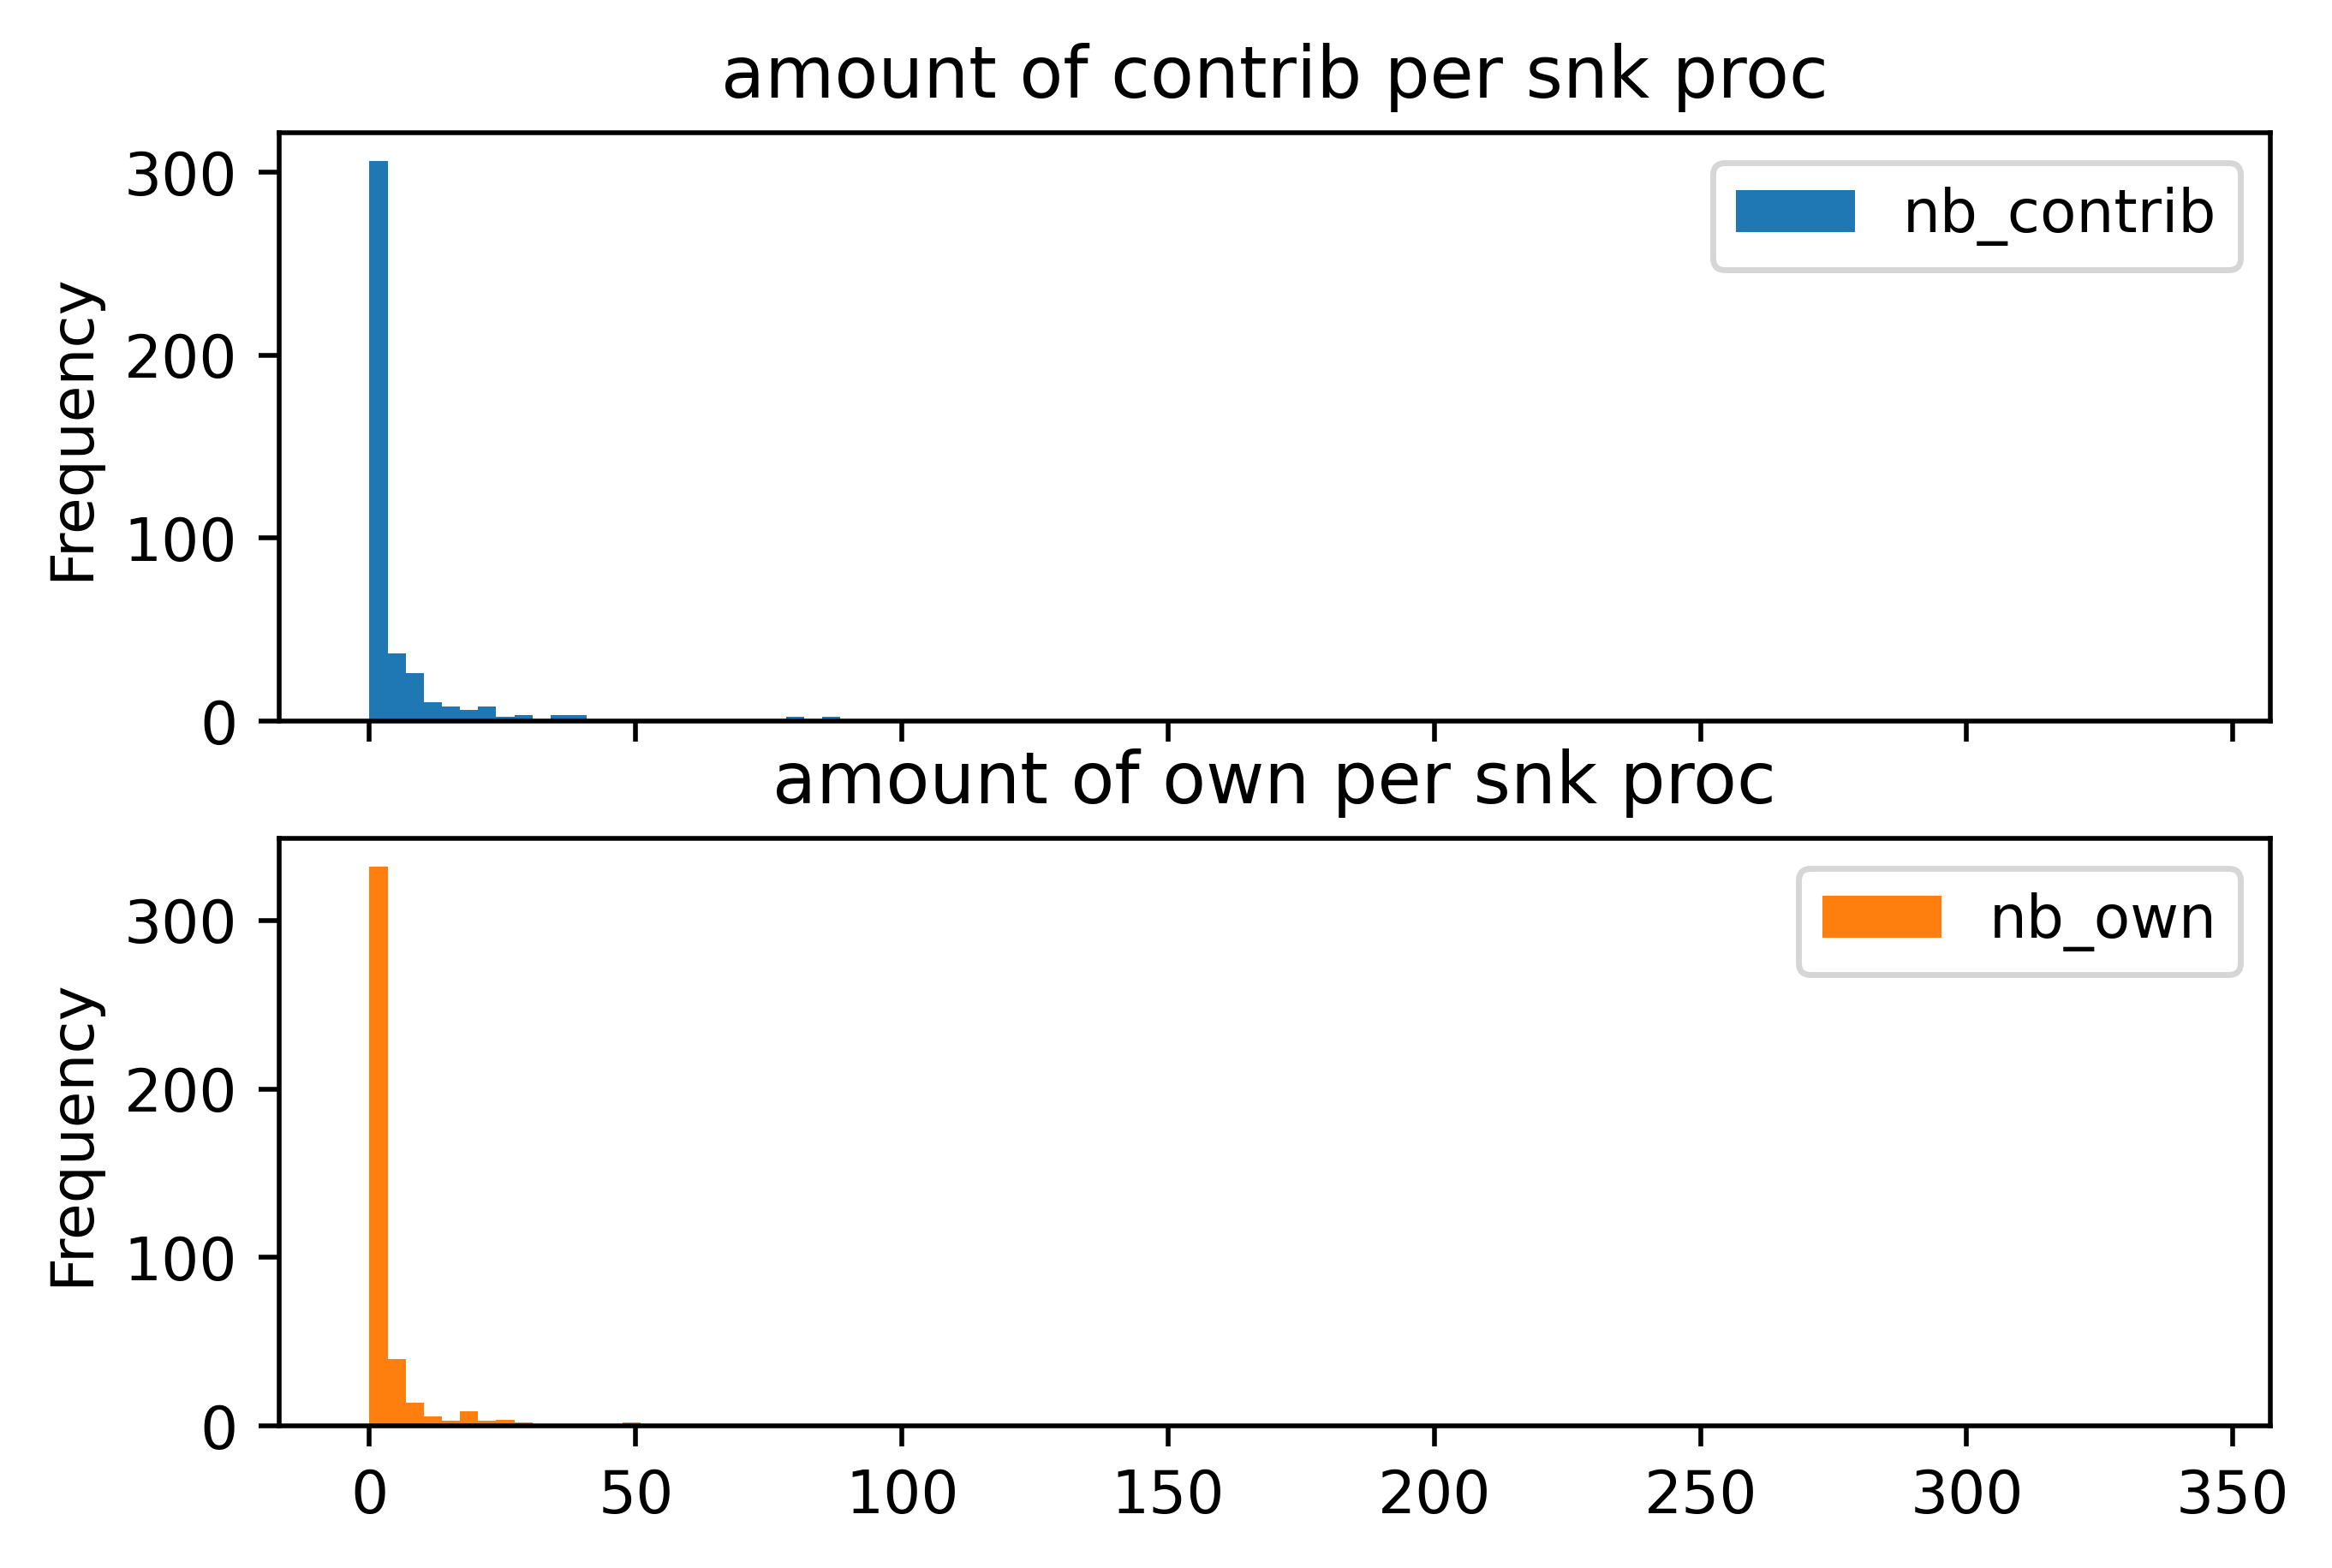

In [78]:
title_list =["amount of contrib per snk proc", "amount of own per snk proc"]
df_sim_snk[["nb_contrib", "nb_own"]].plot(kind='hist', subplots=True,bins=100, title=title_list)

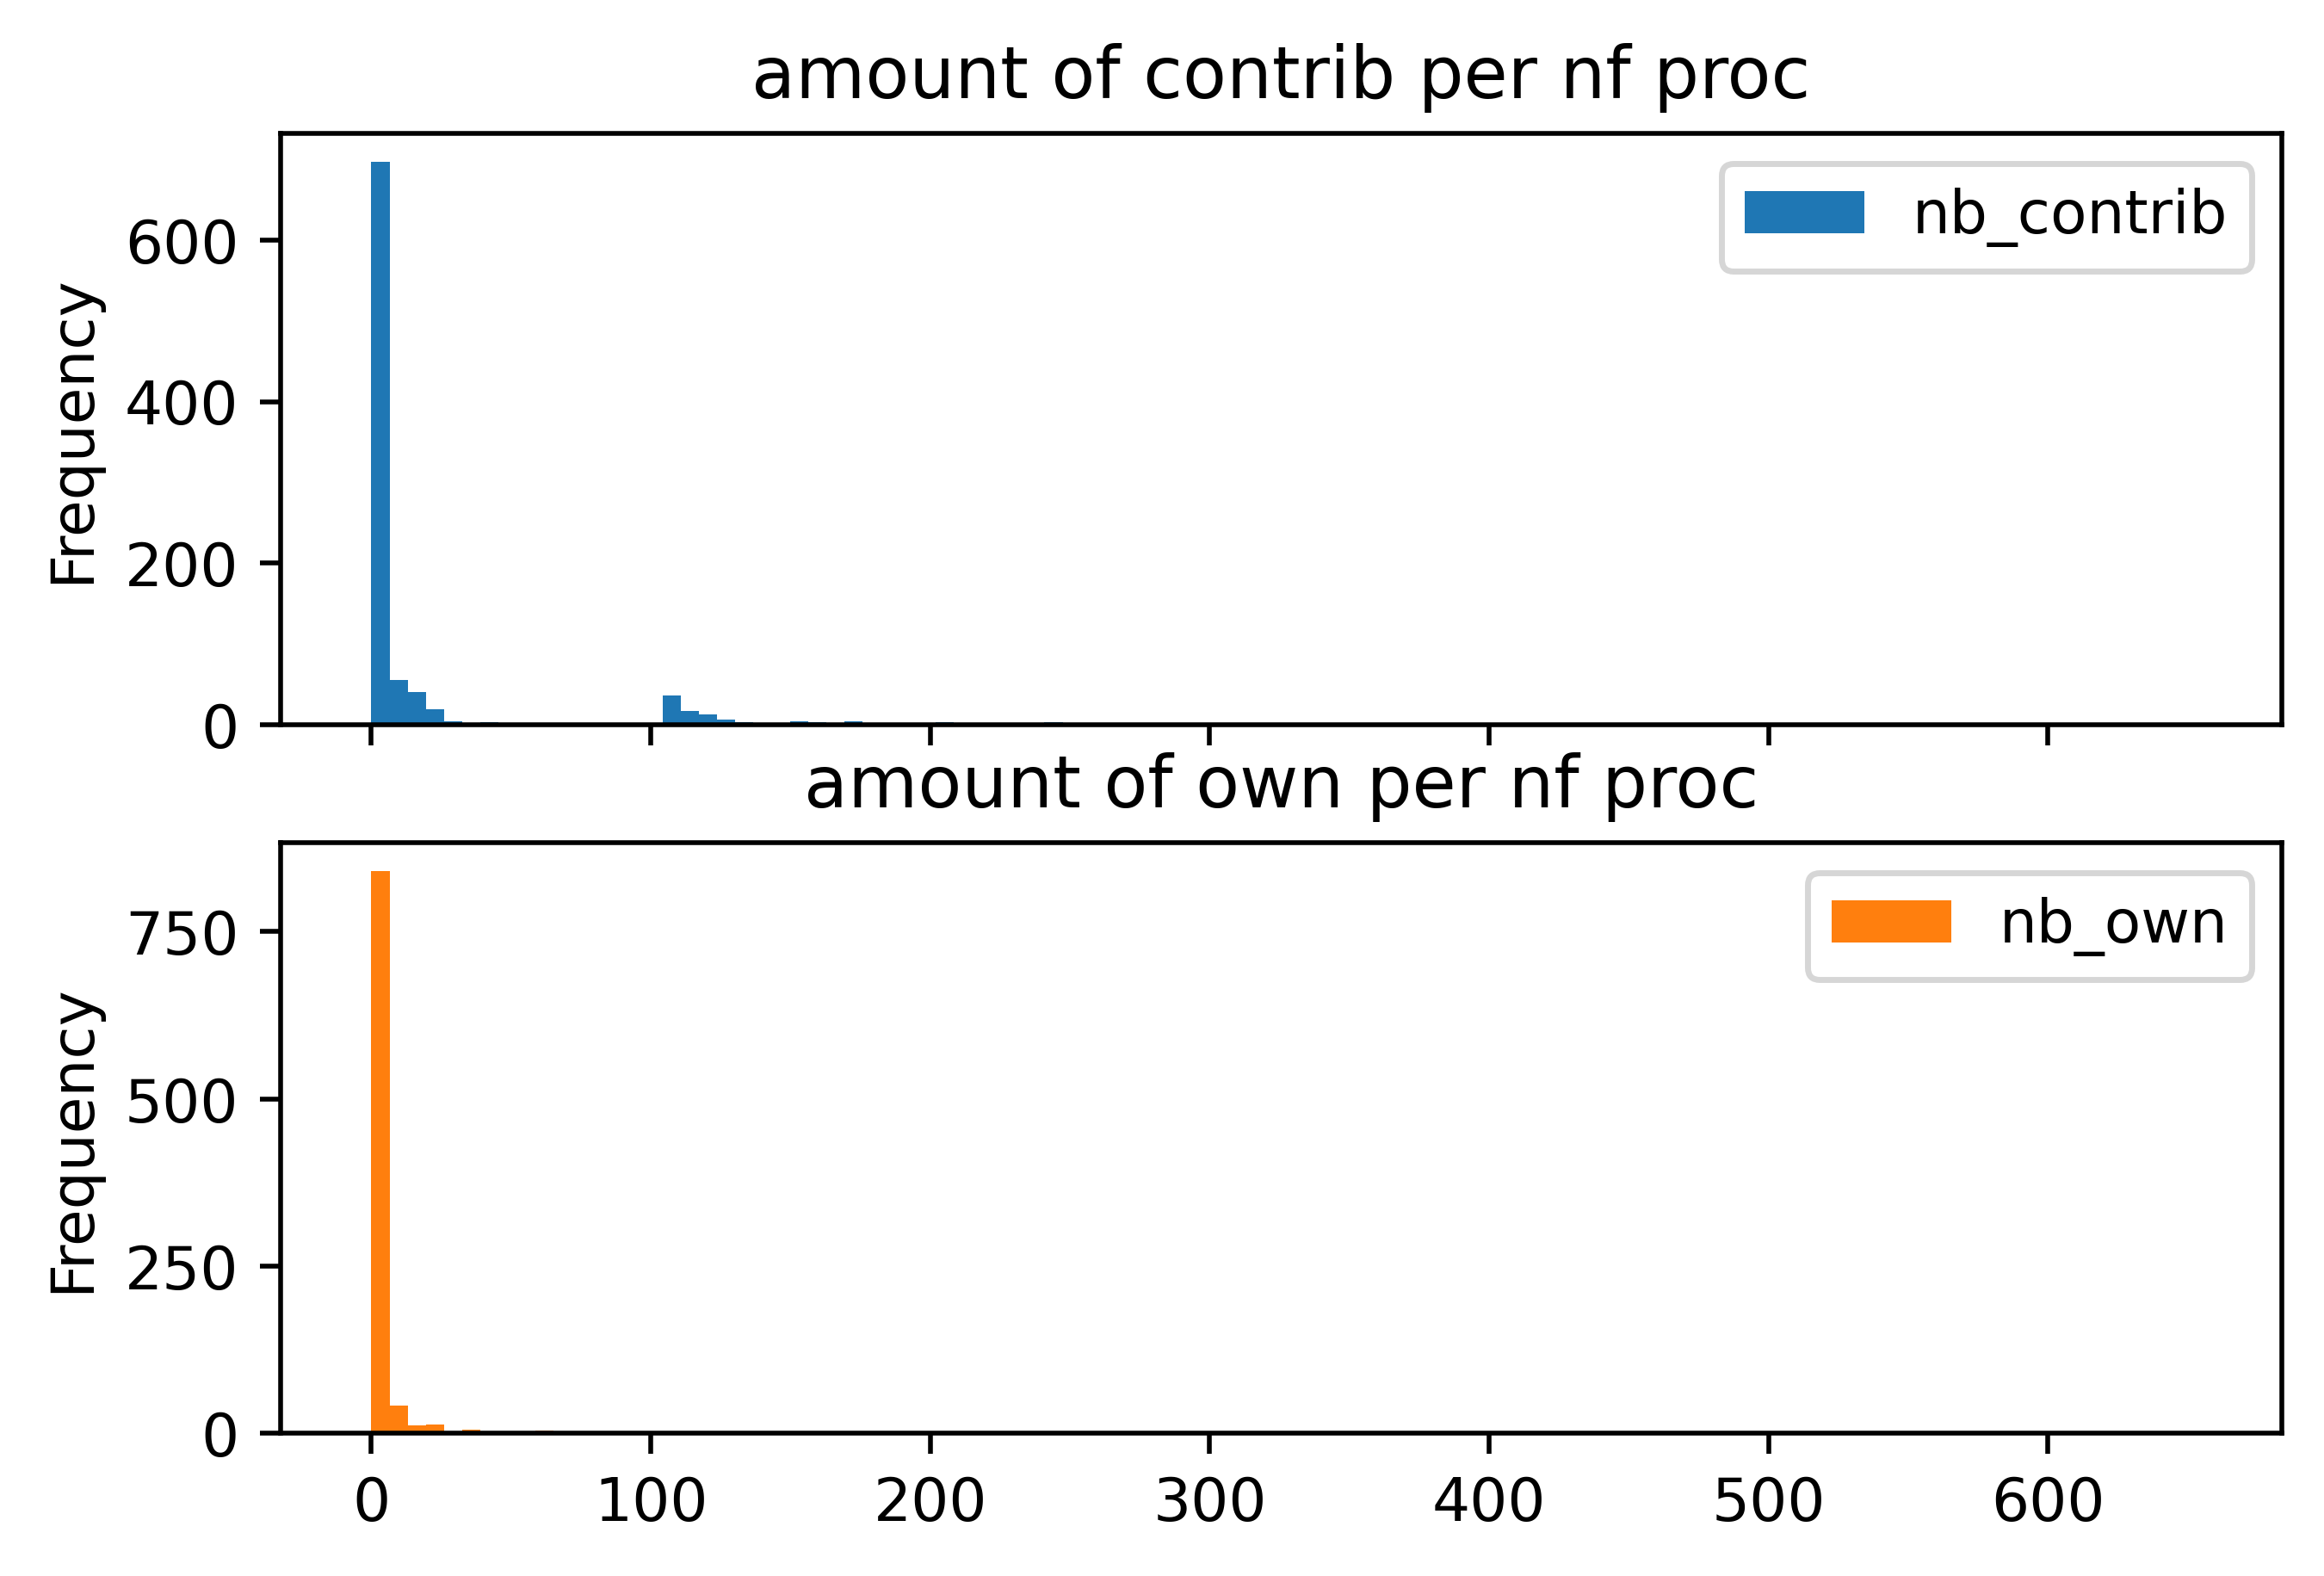

In [80]:
title_list =["amount of contrib per nf proc", "amount of own per nf proc"]
plot_contr_proc_nf = df_sim_nf.plot(y = ["nb_contrib", "nb_own"], kind='hist', subplots=True,bins=100, title=title_list)
#plot_contr_proc_nf.set_yscale('log')